In [253]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler #normalisation
from sklearn.metrics import accuracy_score #scoring
from collections import defaultdict, Counter

In [254]:
# leitura de dados BankNote
data_file = "../dataset/sample-data/banknote.xlsx"

# Read the Excel file using pandas
df = pd.read_excel(data_file)

In [255]:
X = df.iloc[:, :-1].values # Features (all columns except the last one)
y = df.iloc[:, -1].values  # Labels (the last column)
X_train_, X_test, y_train_, y_test = train_test_split(X, y, stratify=y,test_size=0.05)
X_train, X_val, y_train, y_val = train_test_split(X_train_, y_train_, stratify=y_train_,test_size=0.15)

In [256]:
# Get the column names from the original dataframe (excluding the class column)
feature_names = df.columns[:-1].tolist()

# Combine X_test and y_test into a single DataFrame with proper column names
test_data = pd.DataFrame(X_test, columns=feature_names)
test_data['class'] = y_test
test_data.to_csv("../dataset/sample-data/banknote_test_complete.csv", index=False)

# Combine X_train and y_train into a single DataFrame with proper column names
train_data = pd.DataFrame(X_train, columns=feature_names)
train_data['class'] = y_train
train_data.to_csv("../dataset/sample-data/banknote_train_complete.csv", index=False)

# Combine X_val and y_val into a single DataFrame with proper column names
val_data = pd.DataFrame(X_val, columns=feature_names)
val_data['class'] = y_val
val_data.to_csv("../dataset/sample-data/banknote_val_complete.csv", index=False)

In [257]:
df = pd.read_csv("../dataset/sample-data/banknote_train_complete.csv")
df_val = pd.read_csv("../dataset/sample-data/banknote_val_complete.csv")

Sem entropy

In [258]:
df_s_entropy = df.copy().drop(columns=["entropy",])
df_s_entropy_val = df_val.copy().drop(columns=["entropy",])


In [259]:
# Extract data into NumPy arrays
X_s_entropy_train = df_s_entropy.iloc[:, :-1].values # Features (all columns except the last one)
y_s_entropy_train = df_s_entropy.iloc[:, -1].values  # Labels (the last column)

X_s_entropy_val = df_s_entropy_val.iloc[:, :-1].values # Features (all columns except the last one)
y_s_entropy_val = df_s_entropy_val.iloc[:, -1].values  # Labels (the last column)

In [260]:
# fit scaler
X_s_entropy_train = StandardScaler().fit_transform(X_s_entropy_train)
X_s_entropy_val = StandardScaler().fit_transform(X_s_entropy_val)

In [ ]:
#### Configurações
# Map and data dimensions
map_width = 10
map_height = 10
n_features = X_s_entropy_train.shape[1]  # 8 features
print("Núnmero de atributos:", n_features)
# Random initialization of neuron weights
weights_s_entropy = np.random.rand(map_width, map_height, n_features)

# Learning parameters
learning_rate = 0.4
n_iterations = 20000
initial_radius = max(map_width, map_height) / 2
time_constant = n_iterations / np.log(initial_radius)

Núnmero de atributos: 3


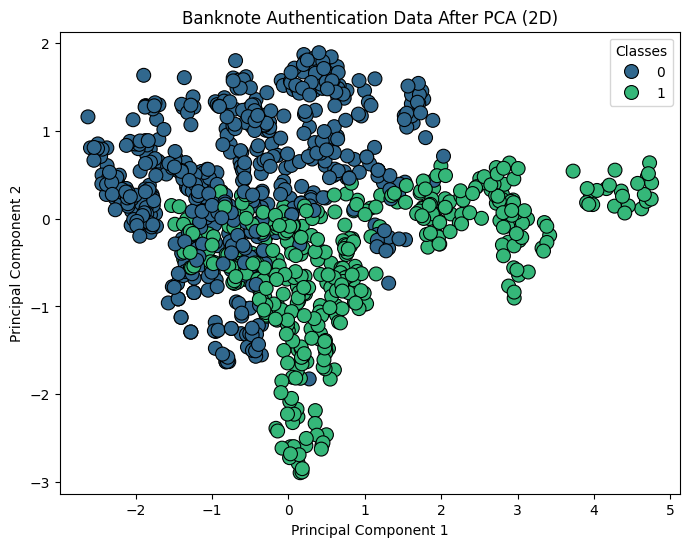

In [262]:
# Function to visualize the data after PCA
def visualize_data_pca(X, y):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette="viridis", s=100, edgecolor='k')
    plt.title("Banknote Authentication Data After PCA (2D)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Classes", loc="upper right")
    plt.show()

# Call the function to visualize the original data
visualize_data_pca(X_s_entropy_train, y_s_entropy_train)

-------- 0 --------


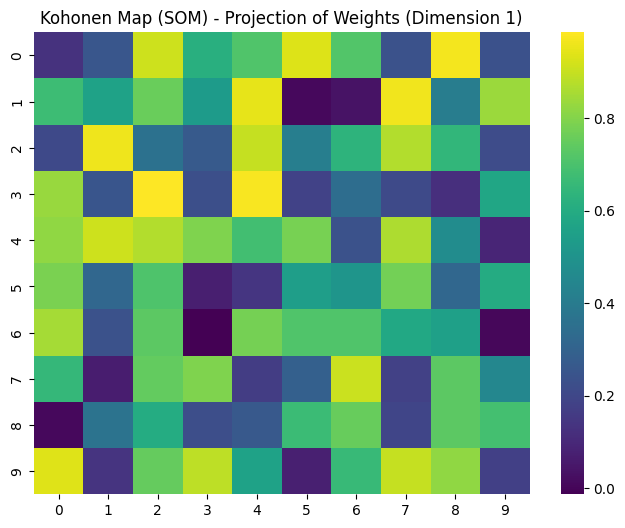

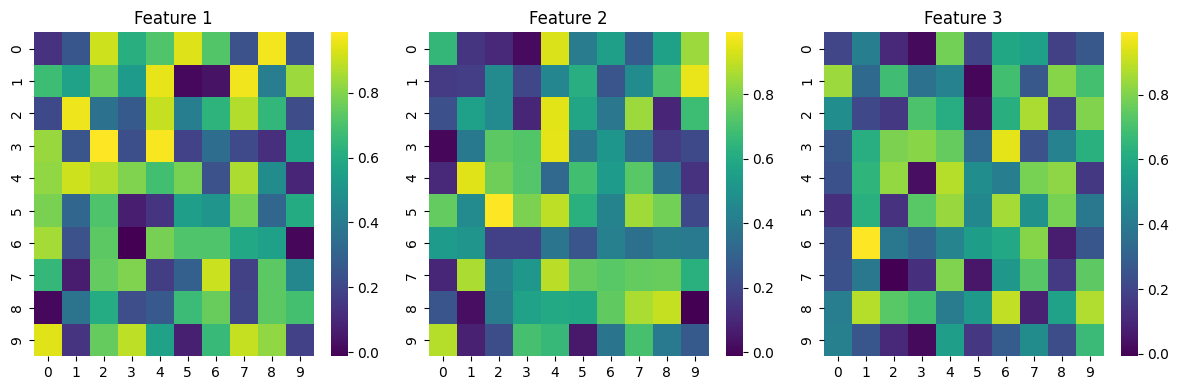

-------- 1000 --------


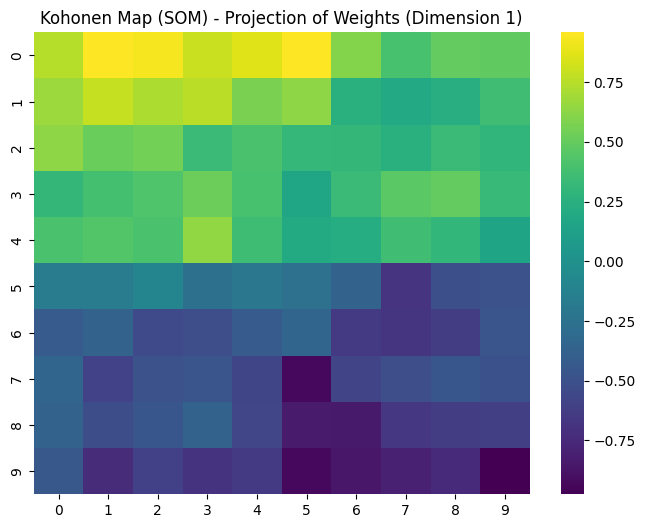

-------- 2000 --------


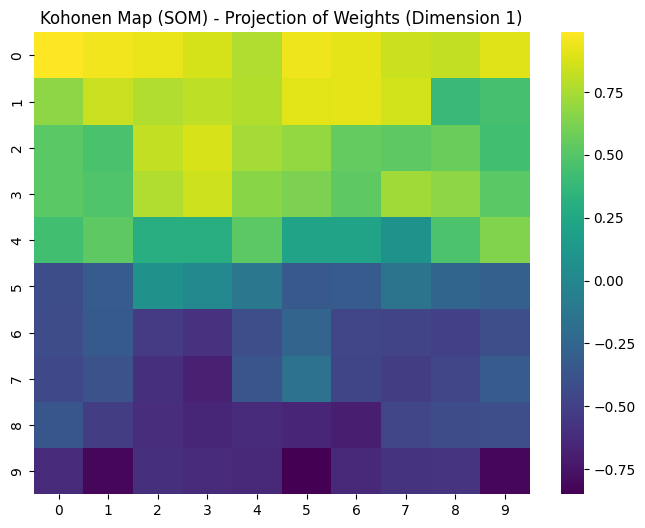

-------- 3000 --------


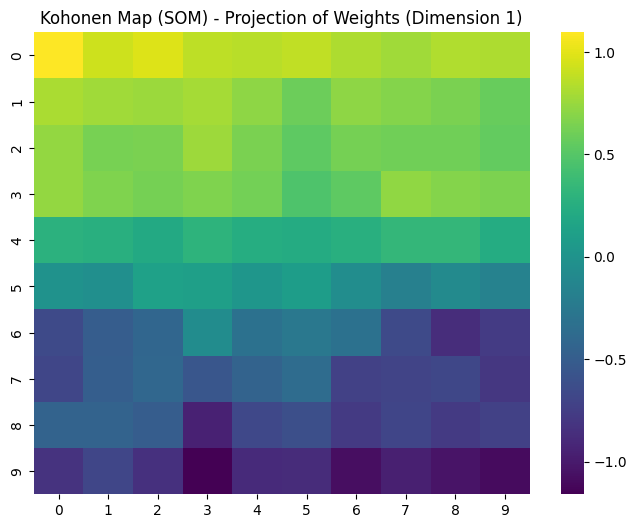

-------- 4000 --------


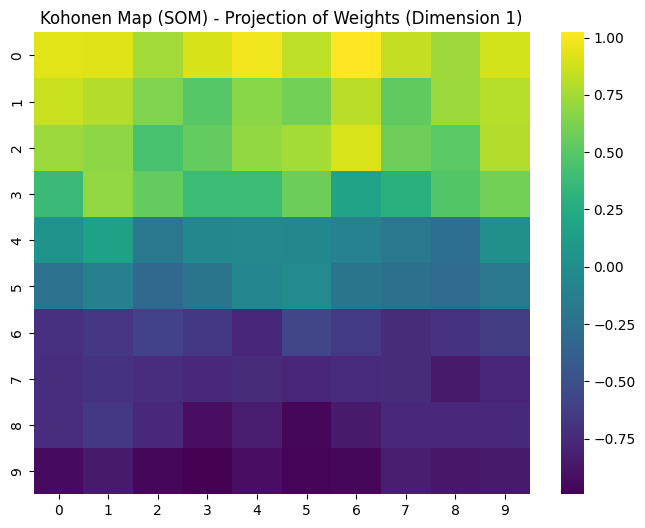

-------- 5000 --------


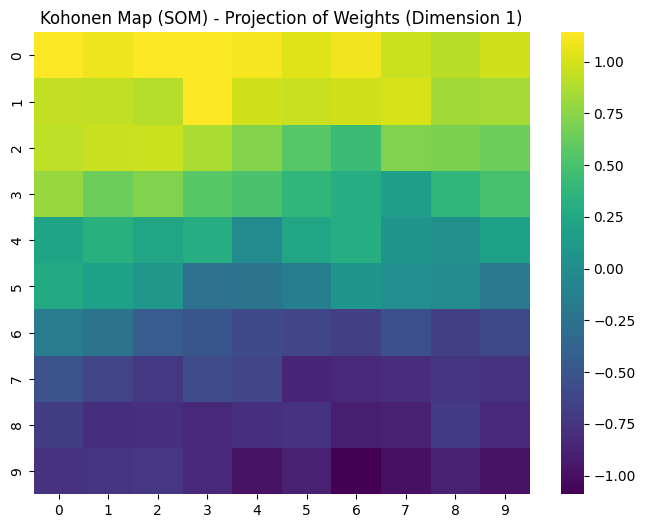

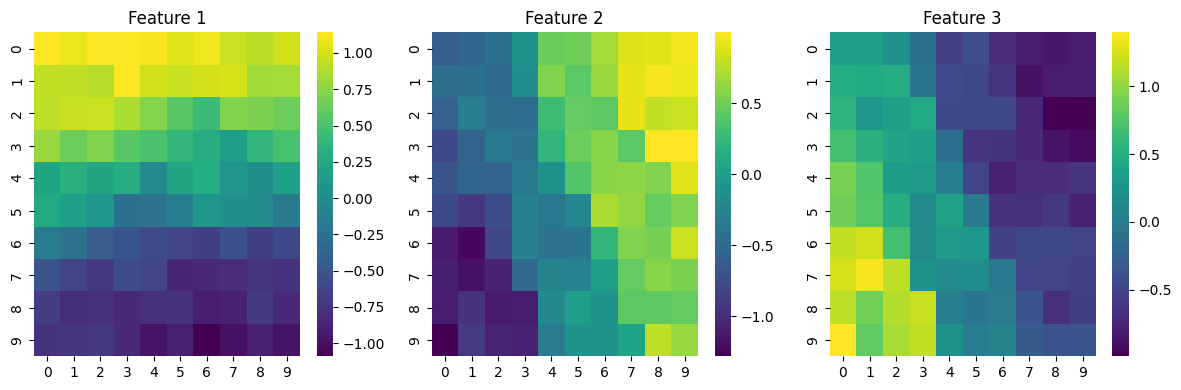

-------- 6000 --------


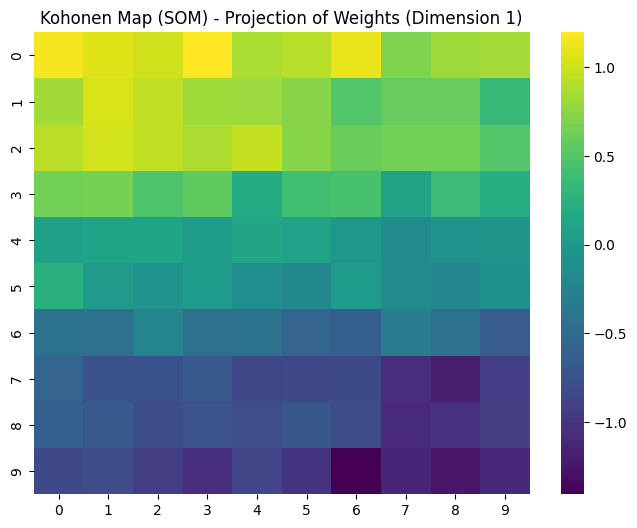

-------- 7000 --------


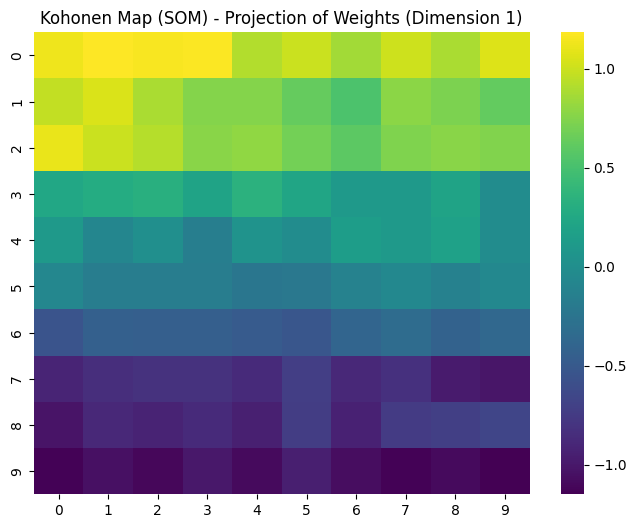

-------- 8000 --------


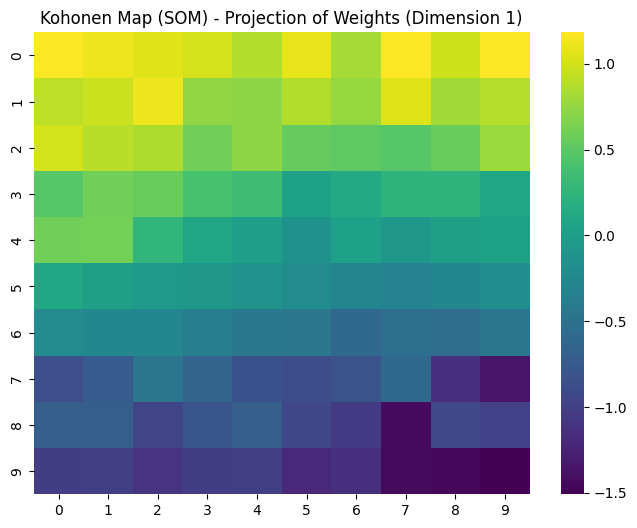

-------- 9000 --------


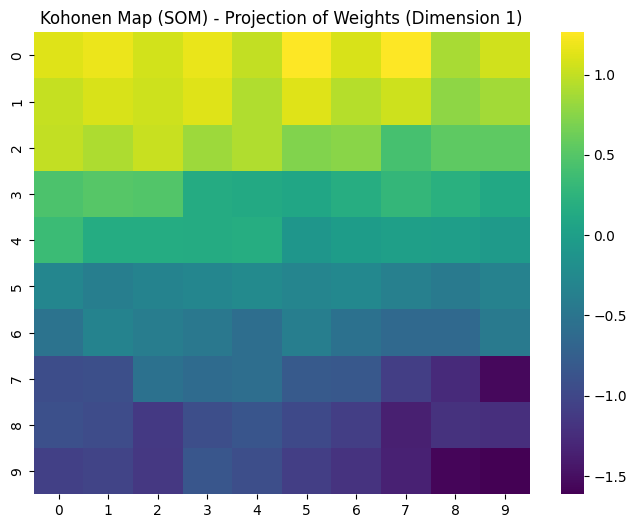

-------- 10000 --------


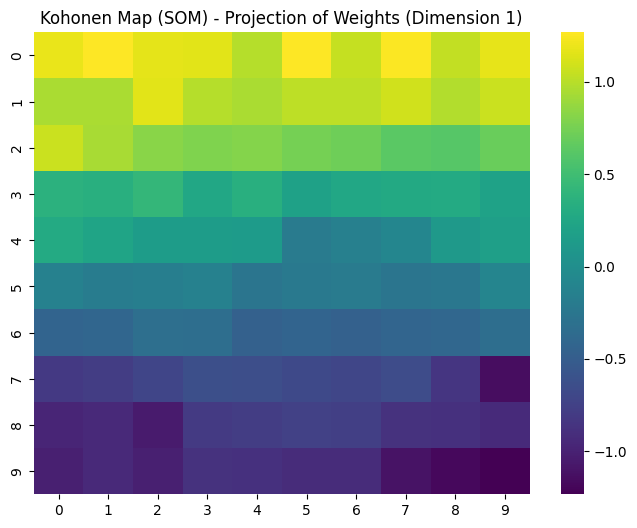

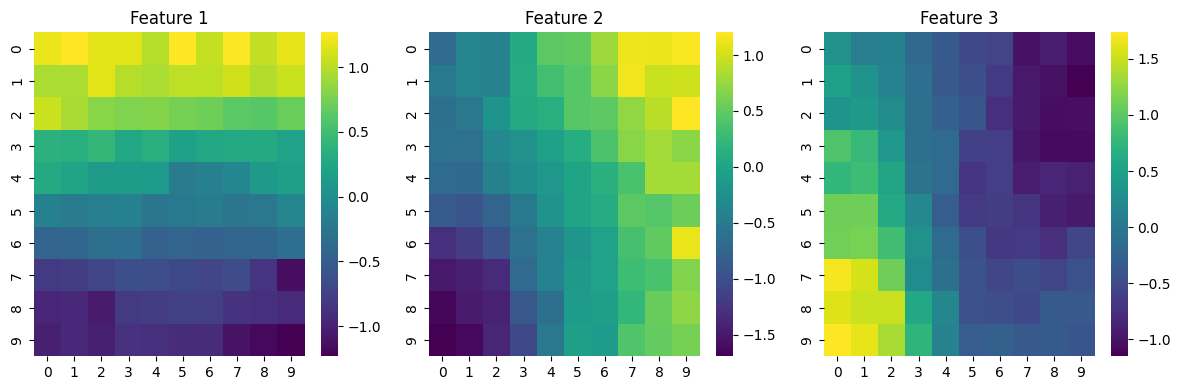

-------- 11000 --------


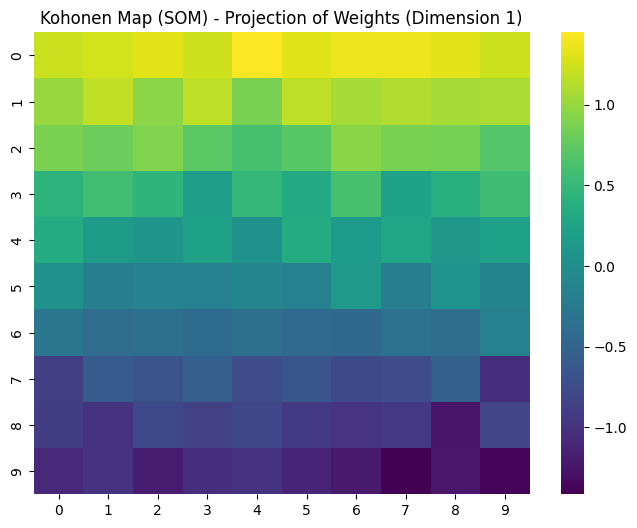

-------- 12000 --------


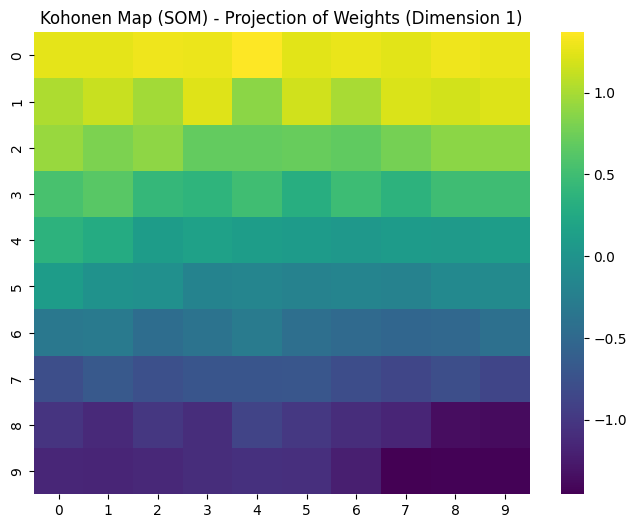

-------- 13000 --------


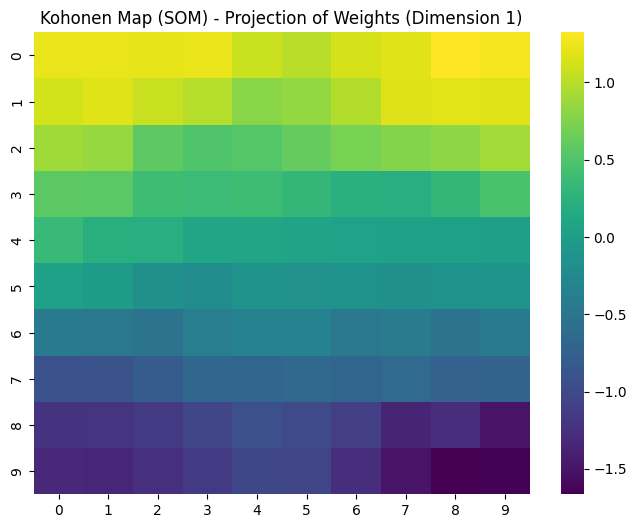

-------- 14000 --------


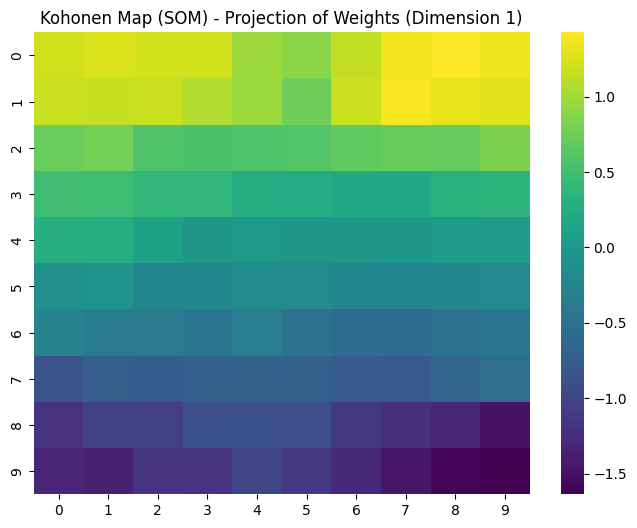

-------- 15000 --------


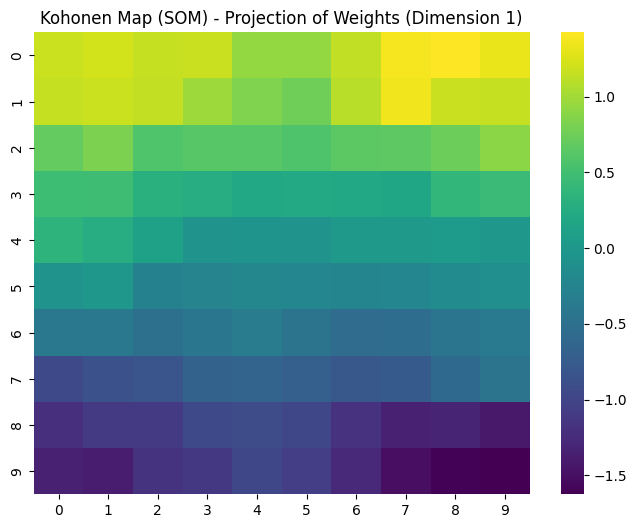

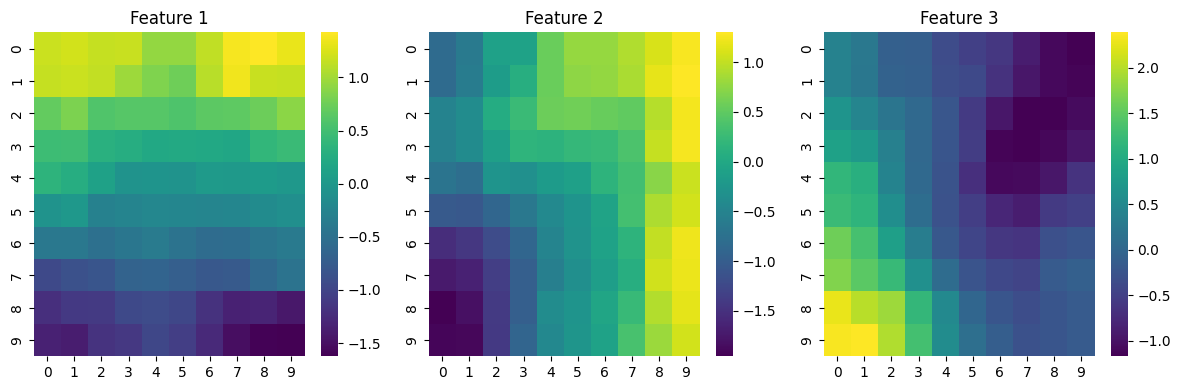

-------- 16000 --------


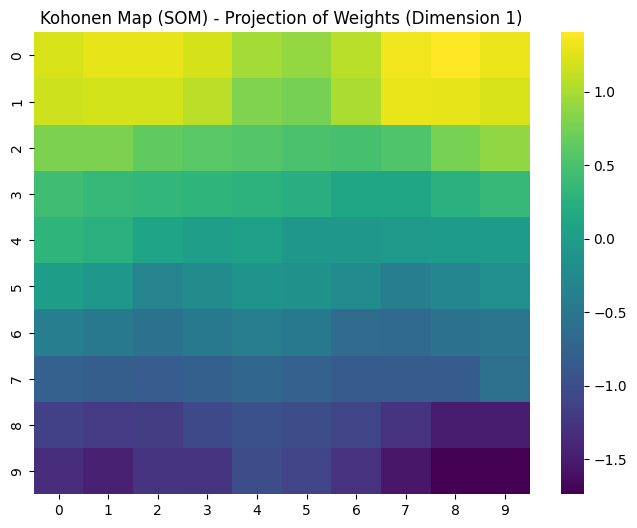

-------- 17000 --------


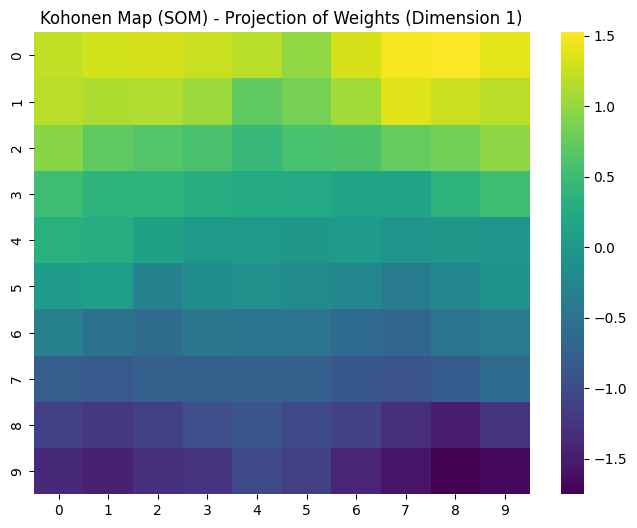

-------- 18000 --------


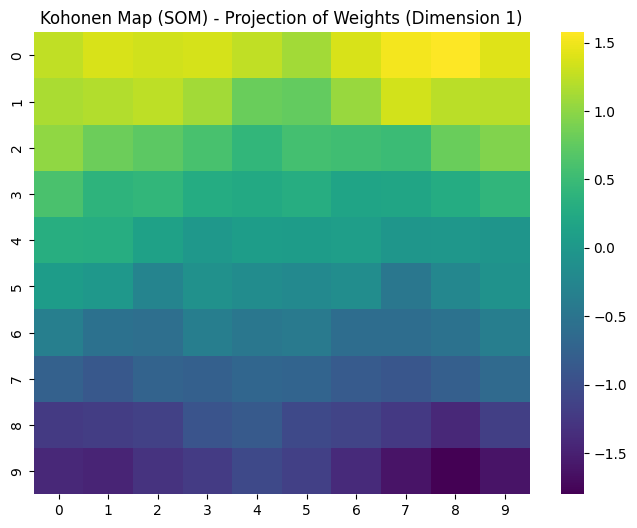

-------- 19000 --------


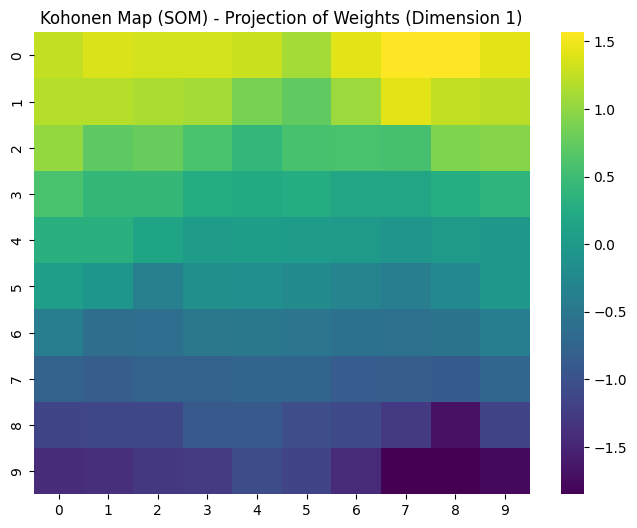

In [263]:
# Find the Best Matching Unit (BMU)
def find_bmu(input_vector, weights):
    bmu_idx = None
    min_dist = np.inf

    # Compare with each neuron
    for i in range(map_width):
        for j in range(map_height):
            w = weights[i, j]
            dist = euclidean_distance(input_vector, w)
            if dist < min_dist:
                min_dist = dist
                bmu_idx = (i, j)

    return bmu_idx
  
# Euclidean distance function
def euclidean_distance(v1, v2):
    return np.linalg.norm(v1 - v2)
  
# Mexican hat function for calculating influence
def mexican_hat_function(dist_to_bmu, radius):
    gaussian_part = np.exp(-dist_to_bmu**2 / (2 * radius**2))  # Excitation (Gaussian part)
    inhibitory_part = np.exp(-dist_to_bmu**2 / (radius**2))  # Inhibition part
    return gaussian_part - inhibitory_part  # Excitation minus inhibition


  
# Update neuron weights using the Mexican Hat function
def update_weights_mexican_hat(input_vector, bmu_idx, iteration, weights, map_width, map_height, learning_rate, time_constant):
    # Calculate neighborhood radius with exponential decay
    radius = initial_radius * np.exp(-iteration / time_constant)

    # Update weights of neurons within BMU's neighborhood
    for i in range(map_width):
        for j in range(map_height):
            w = weights[i, j]
            dist_to_bmu = euclidean_distance(np.array([i, j]), np.array(bmu_idx))

            # If the neuron is within the neighborhood
            if dist_to_bmu < radius:
                # Calculate influence using the Mexican Hat function
                influence = mexican_hat_function(dist_to_bmu, radius)
                # Update weights based on calculated influence
                weights[i, j] += influence * learning_rate * (input_vector - w)

    return weights
  
# Visualization of the Kohonen map weights (1D projection)
def visualize_som_weights(weights):
    plt.figure(figsize=(8, 6))
    sns.heatmap(weights[:, :, 0], cmap="viridis", annot=False, cbar=True)
    plt.title("Kohonen Map (SOM) - Projection of Weights (Dimension 1)")
    plt.show()
    
def visualize_all_som_weights(weights):
    n_features = weights.shape[2]
    fig, axes = plt.subplots(1, n_features, figsize=(4*n_features, 4))
    
    for i in range(n_features):
        sns.heatmap(weights[:, :, i], cmap="viridis", ax=axes[i], cbar=True)
        axes[i].set_title(f"Feature {i+1}")
    
    plt.tight_layout()
    plt.show()

# Training the KSOM with the Mexican Hat function
for iteration in range(n_iterations):
    # Select a random input vector
    input_vector = X_s_entropy_train[np.random.randint(0, X_s_entropy_train.shape[0])]

    # Find the Best Matching Unit (Best neuron)
    bmu_idx = find_bmu(input_vector, weights_s_entropy)

    # Update the weights of the BMU and neighboring neurons
    weights_s_entropy = update_weights_mexican_hat(input_vector, bmu_idx, iteration, weights_s_entropy, map_width, map_height, learning_rate, time_constant)

    # Gradually reduce the learning rate over iterations
    learning_rate = 0.5 * np.exp(-iteration / n_iterations)
    if iteration%1000==0:
      print("--------",iteration,"--------")
      visualize_som_weights(weights_s_entropy)
    if iteration % 5000 == 0:
      visualize_all_som_weights(weights_s_entropy)

    # Call the function to visualize the map after training

In [264]:
# Function for inference with a new input vector
def infer_som(input_vector, weights):
    # Find the BMU for the new input vector
    bmu_idx = find_bmu(input_vector, weights)
    return bmu_idx

def build_bmu_class_map(X, y, weights):
    bmu_class_map = defaultdict(list)

    for i in range(len(X)):
        bmu = infer_som(X[i], weights)
        # Check if y is a pandas Series and use .iloc, otherwise use direct indexing
        if isinstance(y, pd.Series):
            bmu_class_map[tuple(bmu)].append(y.iloc[i])
        else: # Assume it's a numpy array or similar
            bmu_class_map[tuple(bmu)].append(y[i])


    # Atribui a classe mais comum (votação majoritária) a cada BMU
    bmu_to_class = {bmu: Counter(classes).most_common(1)[0][0]
                    for bmu, classes in bmu_class_map.items()}

    return bmu_to_class

bmu_to_class = build_bmu_class_map(X_s_entropy_train, y_s_entropy_train, weights_s_entropy)
print("BMU to Class Mapping:", bmu_to_class)

BMU to Class Mapping: {(3, 0): np.int64(0), (5, 3): np.int64(1), (8, 6): np.int64(1), (3, 1): np.int64(0), (9, 5): np.int64(1), (1, 0): np.int64(0), (1, 9): np.int64(0), (0, 3): np.int64(0), (5, 5): np.int64(1), (7, 2): np.int64(1), (3, 7): np.int64(1), (2, 8): np.int64(0), (7, 5): np.int64(1), (3, 9): np.int64(0), (0, 0): np.int64(0), (3, 8): np.int64(0), (8, 7): np.int64(1), (0, 6): np.int64(0), (9, 6): np.int64(1), (7, 9): np.int64(0), (7, 7): np.int64(1), (6, 1): np.int64(1), (2, 9): np.int64(0), (9, 7): np.int64(1), (8, 3): np.int64(0), (5, 9): np.int64(0), (2, 0): np.int64(0), (4, 9): np.int64(0), (1, 2): np.int64(0), (0, 8): np.int64(0), (8, 1): np.int64(1), (8, 4): np.int64(1), (7, 8): np.int64(0), (2, 1): np.int64(0), (2, 2): np.int64(0), (7, 0): np.int64(1), (1, 8): np.int64(0), (0, 7): np.int64(0), (0, 2): np.int64(0), (0, 1): np.int64(0), (5, 7): np.int64(1), (7, 1): np.int64(1), (2, 5): np.int64(0), (7, 6): np.int64(1), (9, 2): np.int64(1), (5, 2): np.int64(0), (6, 5): np.

Sem curtosis

In [265]:
df_s_curtosis = df.copy().drop(columns=["curtosis",])
df_s_curtosis_val = df_val.copy().drop(columns=["curtosis",])

In [266]:
# Extract data into NumPy arrays
X_s_curtosis_train = df_s_curtosis.iloc[:, :-1].values # Features (all columns except the last one)
y_s_curtosis_train = df_s_curtosis.iloc[:, -1].values  # Labels (the last column)

X_s_curtosis_val = df_s_curtosis_val.iloc[:, :-1].values # Features (all columns except the last one)
y_s_curtosis_val = df_s_curtosis_val.iloc[:, -1].values  # Labels (the last column)



In [267]:
X_s_curtosis_train = StandardScaler().fit_transform(X_s_curtosis_train)
X_s_curtosis_val = StandardScaler().fit_transform(X_s_curtosis_val)

In [268]:
#### Configurações
# Map and data dimensions
map_width = 10
map_height = 10
n_features = X_s_curtosis_train.shape[1]  # 8 features
print("Núnmero de atributos:", n_features)
# Random initialization of neuron weights
weights_s_curtosis = np.random.rand(map_width, map_height, n_features)

# Learning parameters
learning_rate = 0.4
n_iterations = 20000
initial_radius = max(map_width, map_height) / 2
time_constant = n_iterations / np.log(initial_radius)

Núnmero de atributos: 3


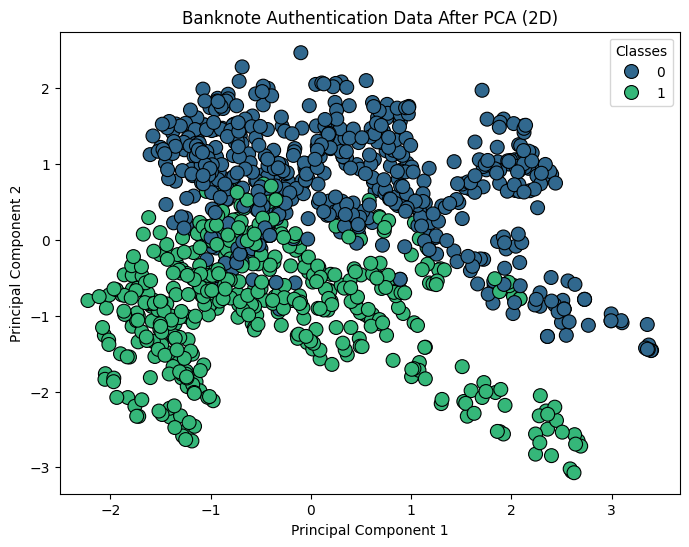

In [269]:
# Call the function to visualize the original data
visualize_data_pca(X_s_curtosis_train, y_s_curtosis_train)

-------- 0 --------


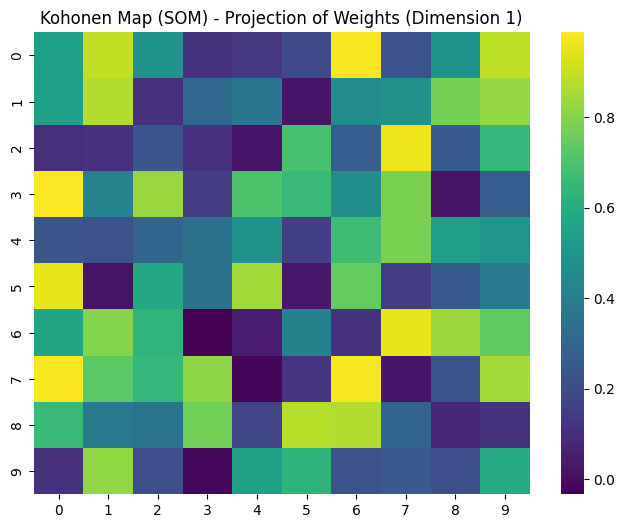

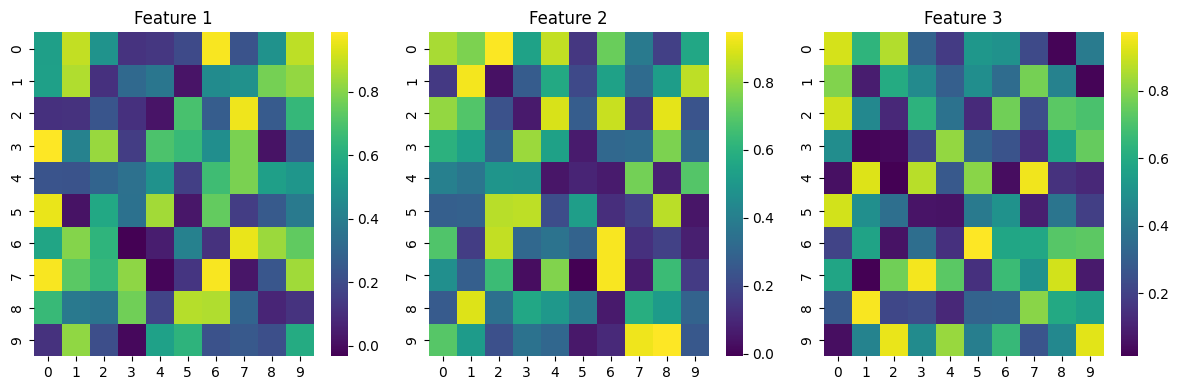

-------- 1000 --------


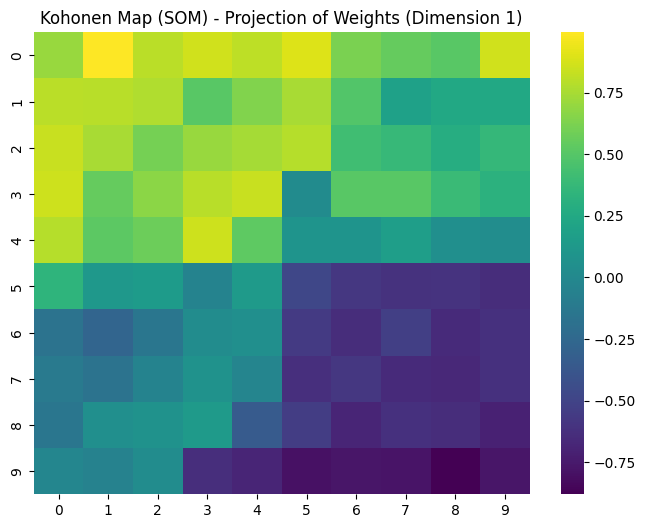

-------- 2000 --------


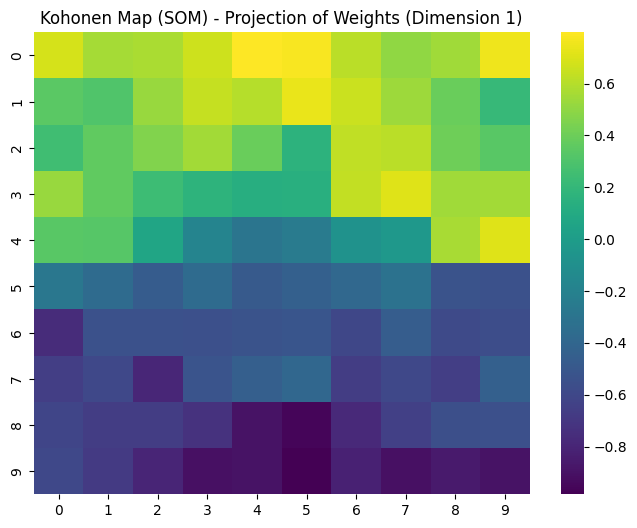

-------- 3000 --------


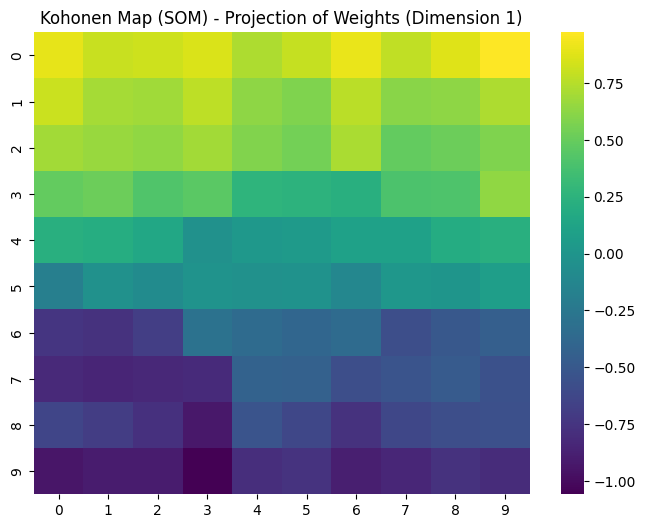

-------- 4000 --------


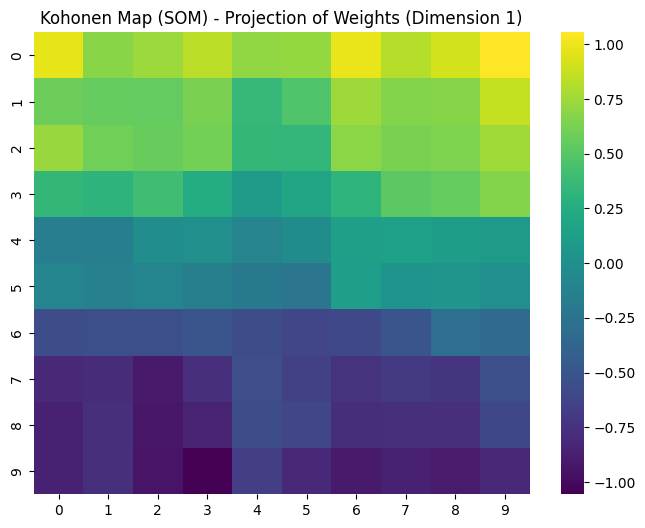

-------- 5000 --------


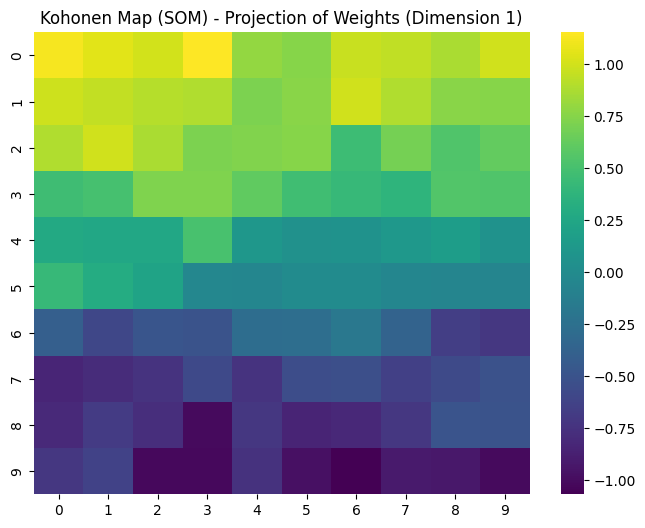

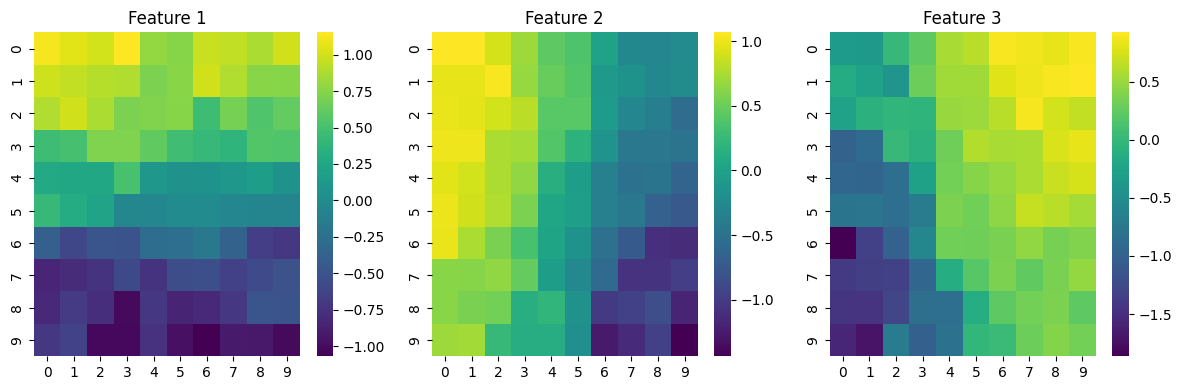

-------- 6000 --------


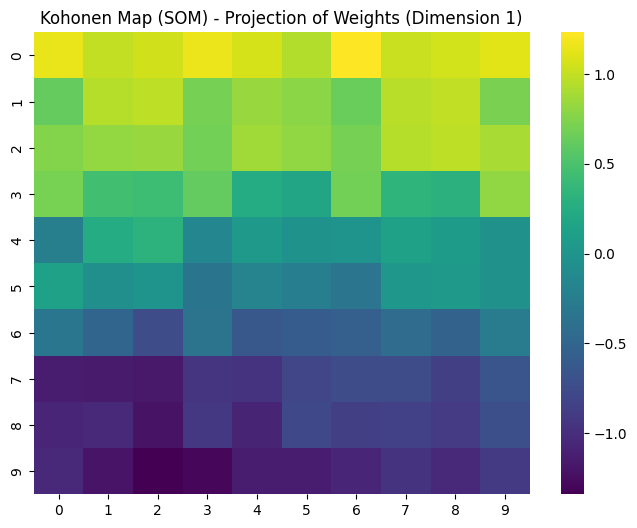

-------- 7000 --------


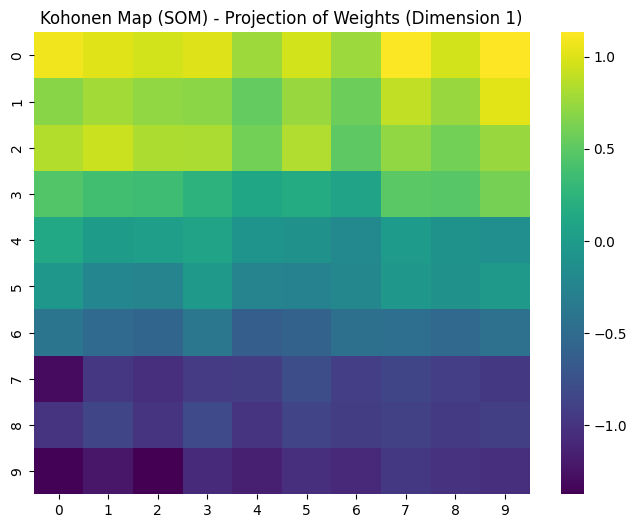

-------- 8000 --------


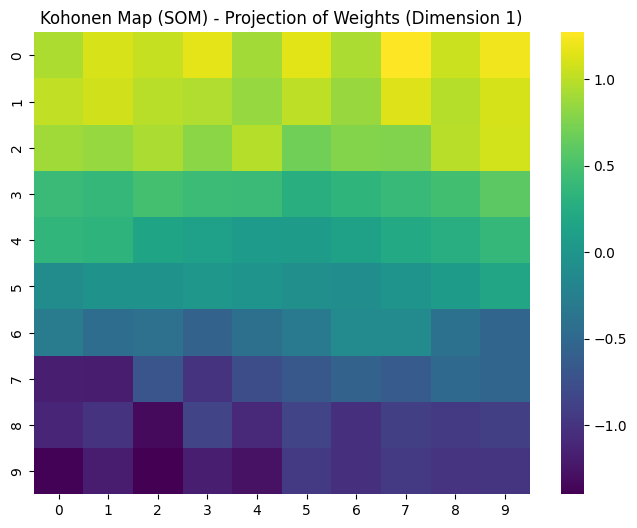

-------- 9000 --------


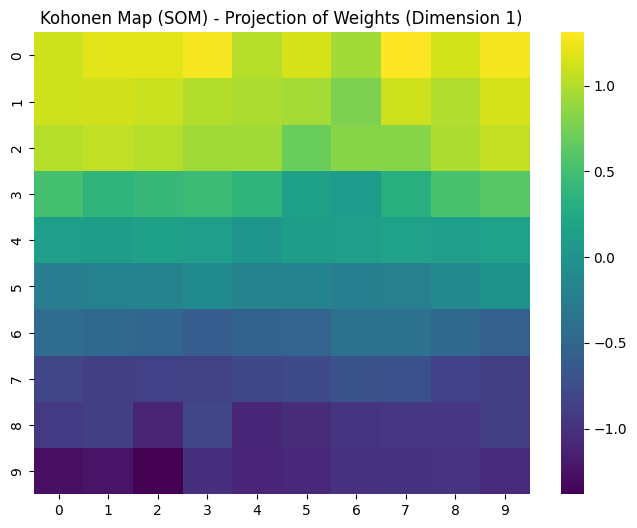

-------- 10000 --------


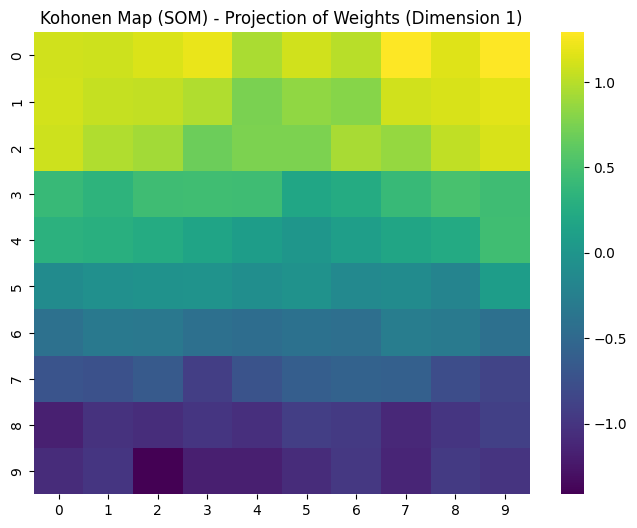

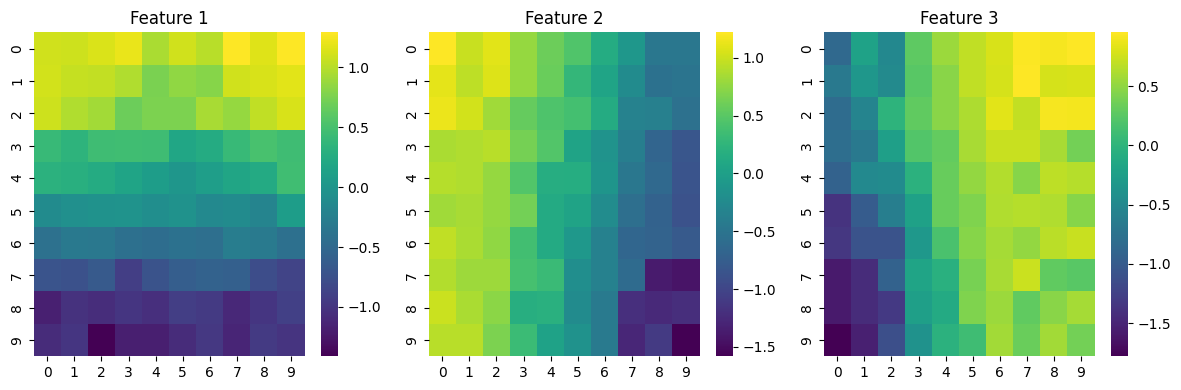

-------- 11000 --------


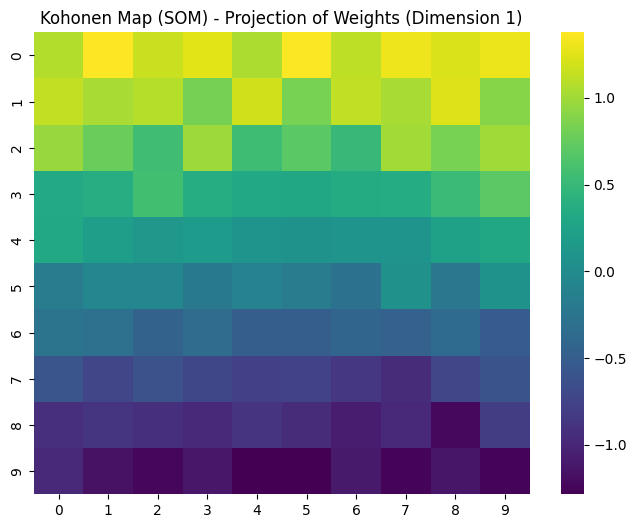

-------- 12000 --------


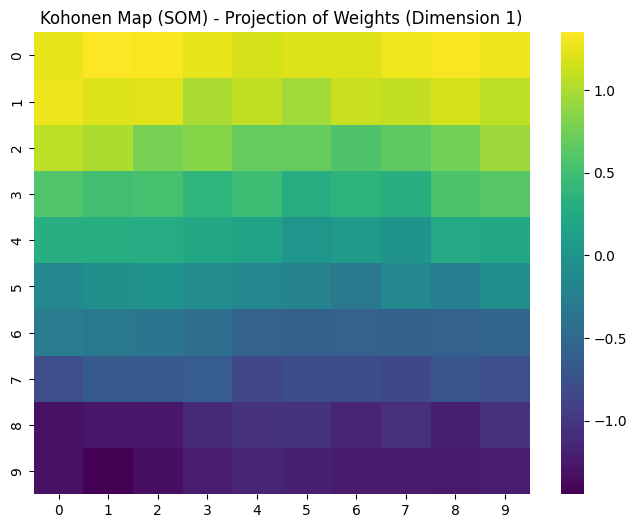

-------- 13000 --------


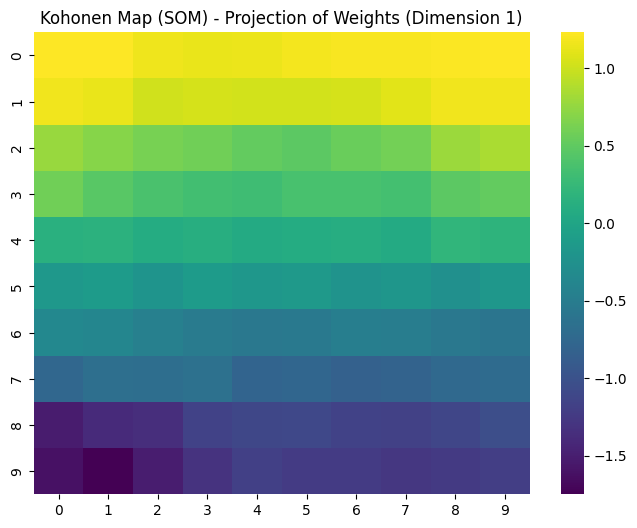

-------- 14000 --------


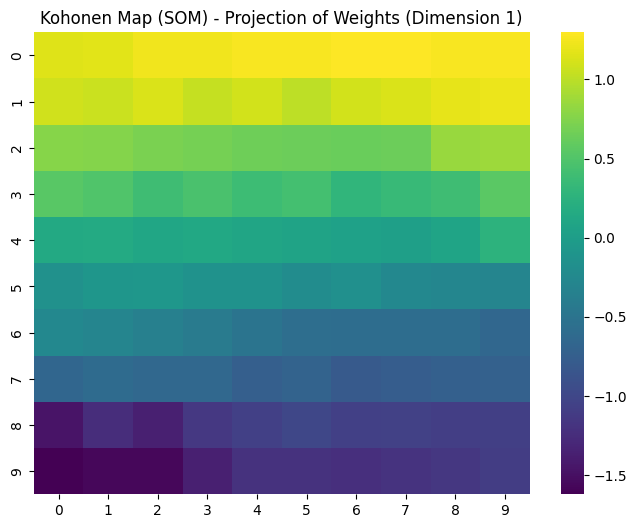

-------- 15000 --------


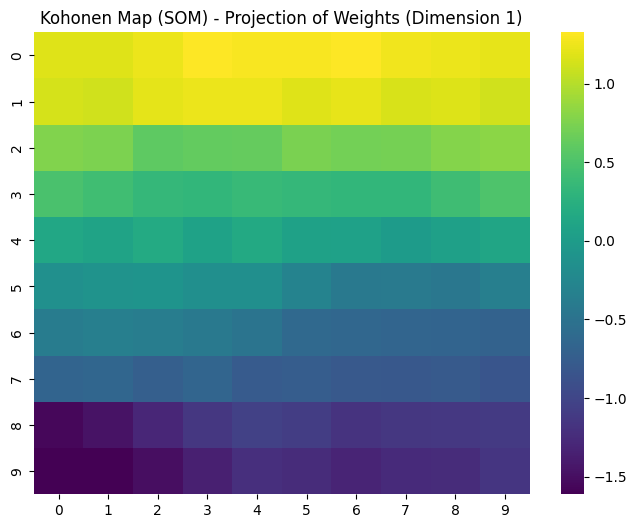

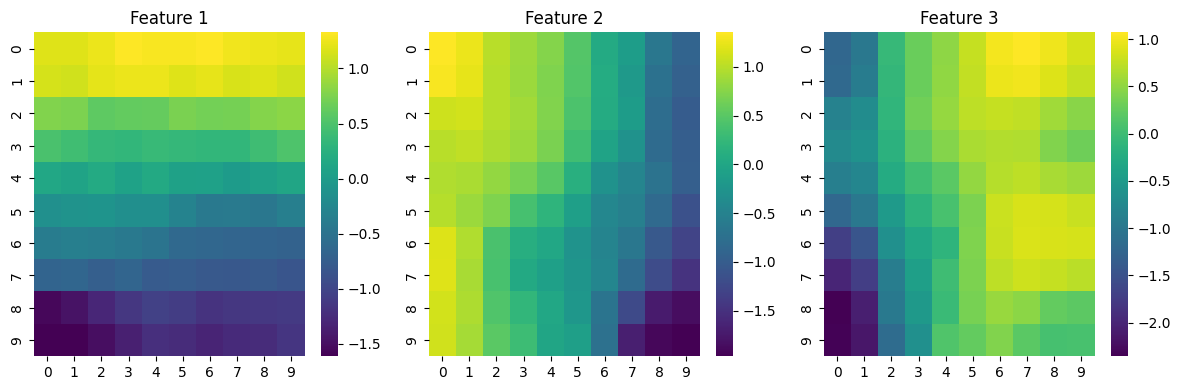

-------- 16000 --------


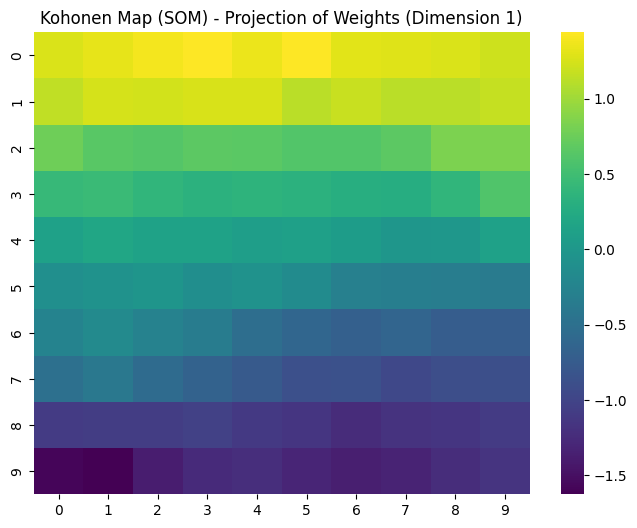

-------- 17000 --------


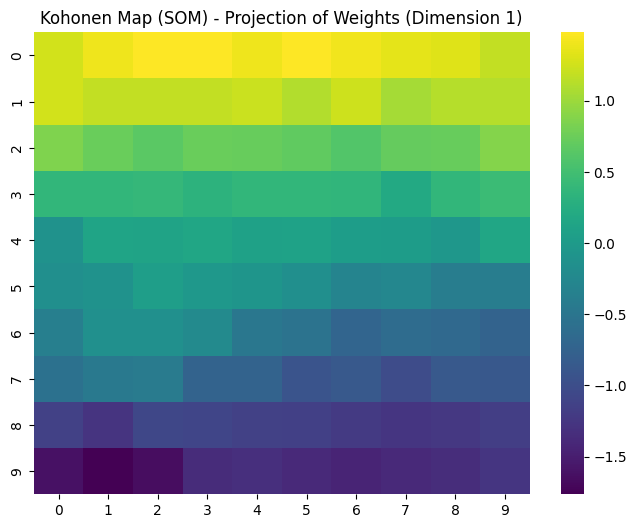

-------- 18000 --------


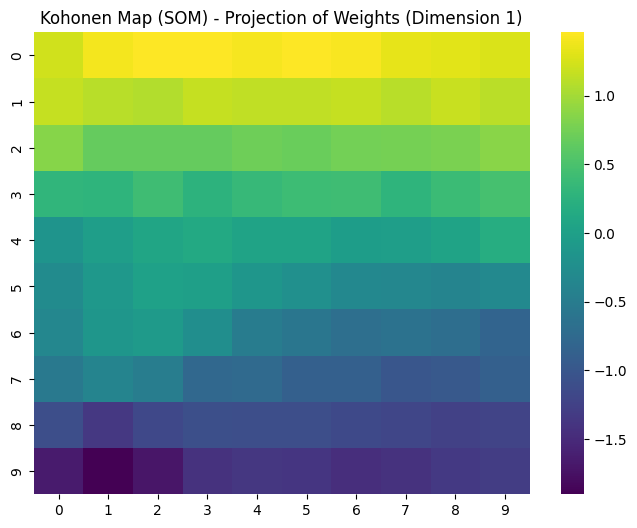

-------- 19000 --------


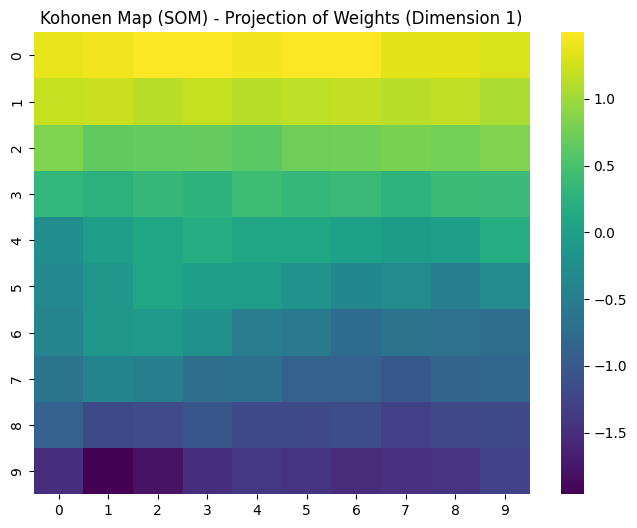

In [270]:
# Training the KSOM with the Mexican Hat function
for iteration in range(n_iterations):
    # Select a random input vector
    input_vector = X_s_curtosis_train[np.random.randint(0, X_s_curtosis_train.shape[0])]

    # Find the Best Matching Unit (Best neuron)
    bmu_idx = find_bmu(input_vector, weights_s_curtosis)

    # Update the weights of the BMU and neighboring neurons
    weights_s_curtosis = update_weights_mexican_hat(input_vector, bmu_idx, iteration, weights_s_curtosis, map_width, map_height, learning_rate, time_constant)

    # Gradually reduce the learning rate over iterations
    learning_rate = 0.5 * np.exp(-iteration / n_iterations)
    if iteration%1000==0:
      print("--------",iteration,"--------")
      visualize_som_weights(weights_s_curtosis)
    if iteration % 5000 == 0:
      visualize_all_som_weights(weights_s_curtosis)

    # Call the function to visualize the map after training

In [271]:
bmu_to_class2 = build_bmu_class_map(X_s_curtosis_train, y_s_curtosis_train, weights_s_curtosis)
print("BMU to Class Mapping:", bmu_to_class2)

BMU to Class Mapping: {(2, 7): np.int64(0), (5, 8): np.int64(1), (7, 5): np.int64(1), (4, 5): np.int64(0), (8, 5): np.int64(1), (0, 8): np.int64(0), (0, 0): np.int64(0), (0, 6): np.int64(0), (5, 7): np.int64(1), (7, 8): np.int64(1), (7, 1): np.int64(1), (2, 2): np.int64(0), (7, 6): np.int64(1), (3, 1): np.int64(0), (1, 0): np.int64(0), (3, 2): np.int64(0), (8, 4): np.int64(1), (0, 4): np.int64(0), (9, 4): np.int64(1), (4, 0): np.int64(0), (8, 2): np.int64(1), (6, 9): np.int64(1), (9, 5): np.int64(1), (2, 0): np.int64(0), (6, 4): np.int64(1), (5, 0): np.int64(0), (6, 0): np.int64(0), (1, 9): np.int64(0), (1, 2): np.int64(0), (6, 8): np.int64(1), (0, 7): np.int64(0), (0, 1): np.int64(0), (8, 8): np.int64(1), (6, 6): np.int64(1), (8, 0): np.int64(0), (3, 8): np.int64(0), (2, 6): np.int64(0), (8, 9): np.int64(1), (1, 3): np.int64(0), (0, 3): np.int64(0), (1, 6): np.int64(0), (2, 9): np.int64(0), (7, 2): np.int64(1), (2, 5): np.int64(0), (3, 4): np.int64(0), (7, 4): np.int64(1), (4, 6): np.

Sem curtosis e entropy

In [272]:
df_s_curtosis_entropy = df.copy().drop(columns=["curtosis", "entropy",])
df_s_curtosis_entropy_val = df_val.copy().drop(columns=["curtosis", "entropy",])

In [273]:
# Extract data into NumPy arrays
X_s_curtosis_entropy_train = df_s_curtosis_entropy.iloc[:, :-1].values # Features (all columns except the last one)
y_s_curtosis_entropy_train = df_s_curtosis_entropy.iloc[:, -1].values  # Labels (the last column)

X_s_curtosis_entropy_val = df_s_curtosis_entropy_val.iloc[:, :-1].values # Features (all columns except the last one)
y_s_curtosis_entropy_val = df_s_curtosis_entropy_val.iloc[:, -1].values  # Labels (the last column)

In [274]:
X_s_curtosis_entropy_train = StandardScaler().fit_transform(X_s_curtosis_entropy_train)
X_s_curtosis_entropy_val = StandardScaler().fit_transform(X_s_curtosis_entropy_val)

In [275]:
#### Configurações
# Map and data dimensions
map_width = 10
map_height = 10
n_features = X_s_curtosis_entropy_train.shape[1]  # 8 features
print("Núnmero de atributos:", n_features)
# Random initialization of neuron weights
weights_s_curtosis_entropy = np.random.rand(map_width, map_height, n_features)

# Learning parameters
learning_rate = 0.4
n_iterations = 20000
initial_radius = max(map_width, map_height) / 2
time_constant = n_iterations / np.log(initial_radius)

Núnmero de atributos: 2


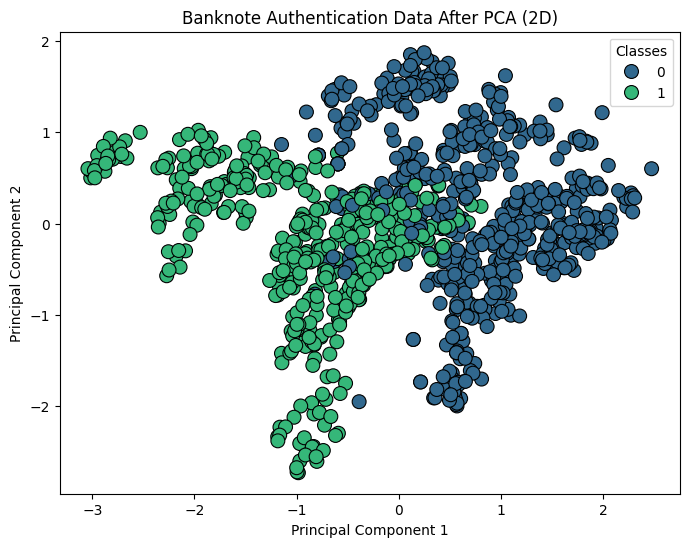

In [276]:
# Call the function to visualize the original data
visualize_data_pca(X_s_curtosis_entropy_train, y_s_curtosis_entropy_train)

-------- 0 --------


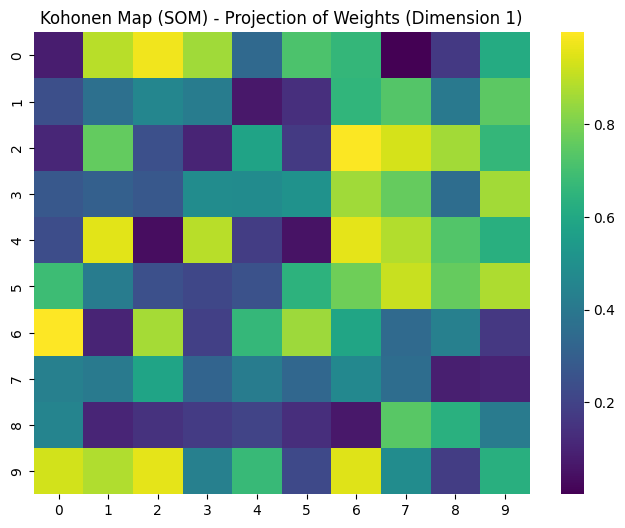

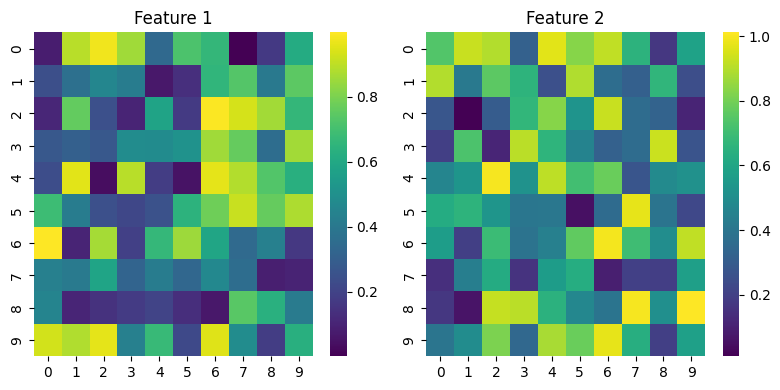

-------- 1000 --------


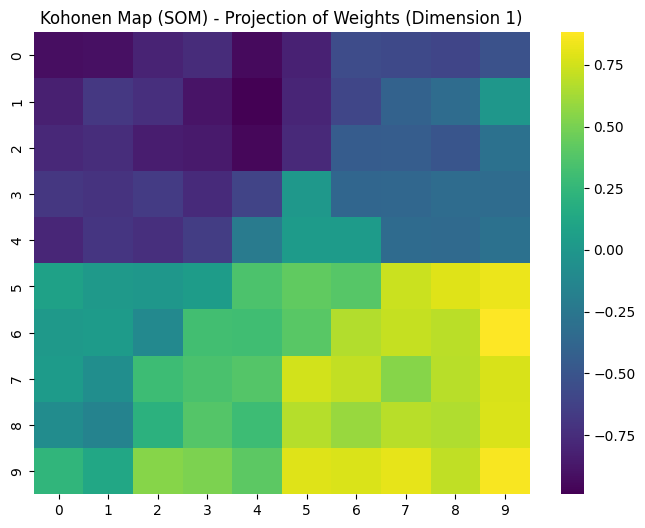

-------- 2000 --------


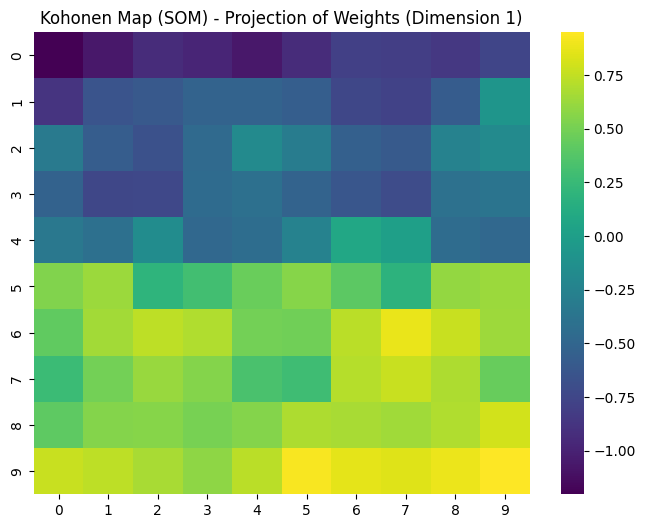

-------- 3000 --------


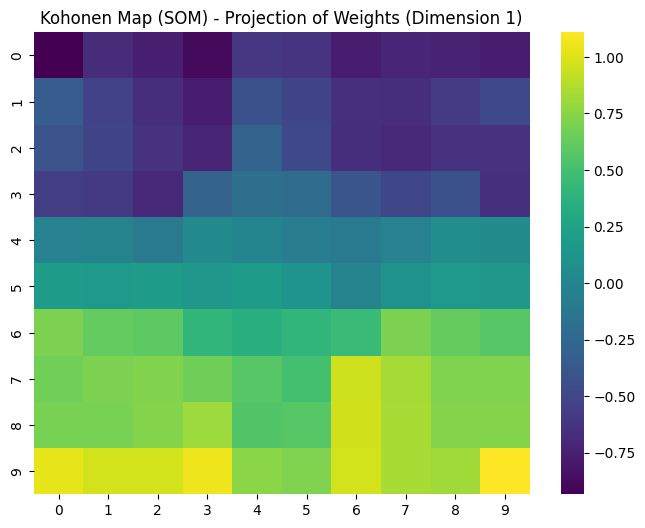

-------- 4000 --------


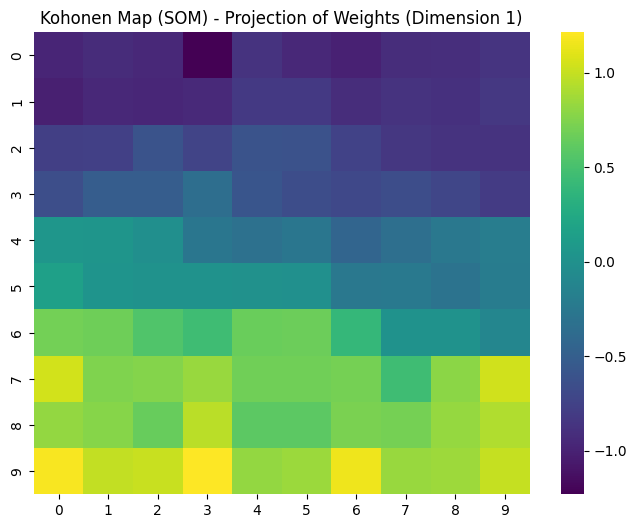

-------- 5000 --------


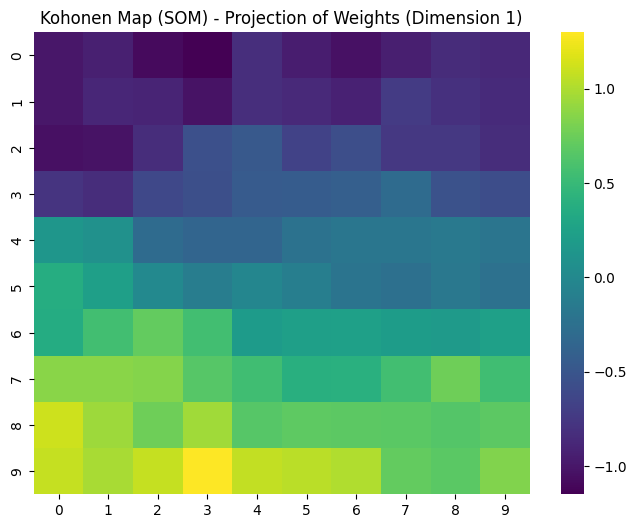

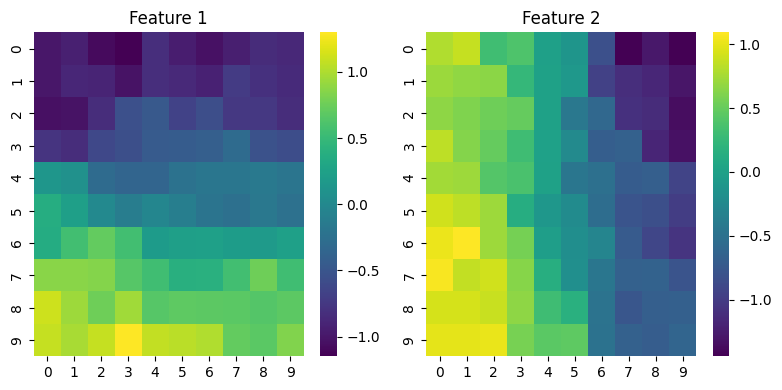

-------- 6000 --------


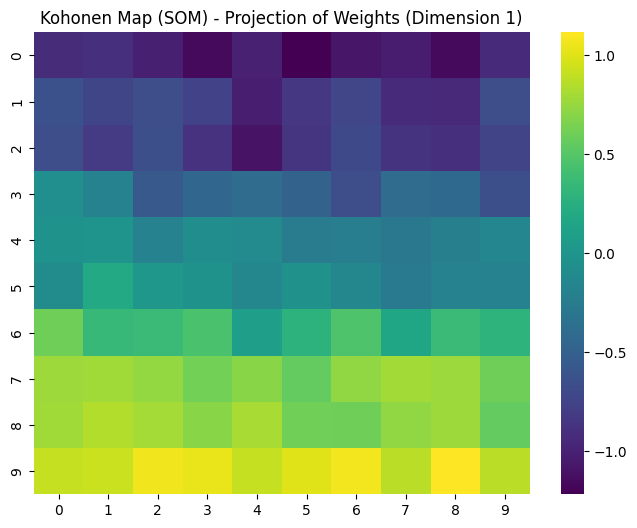

-------- 7000 --------


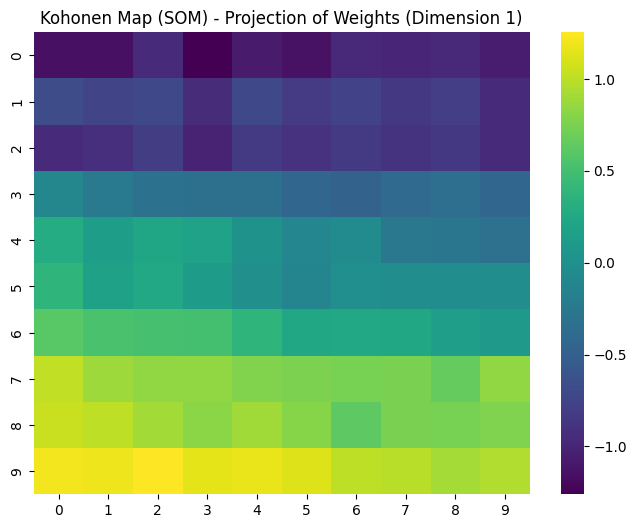

-------- 8000 --------


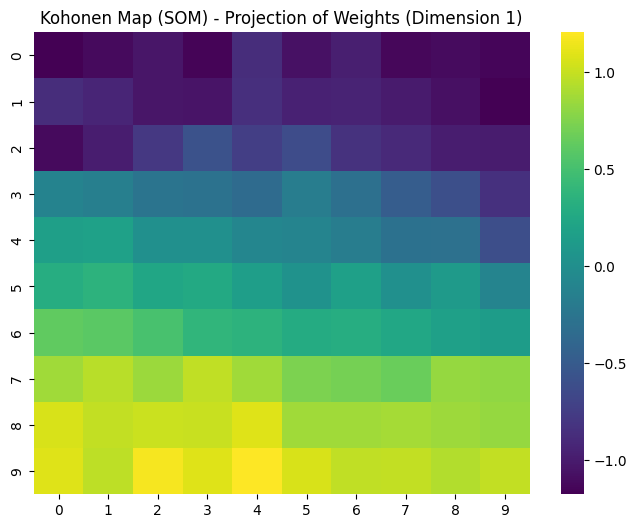

-------- 9000 --------


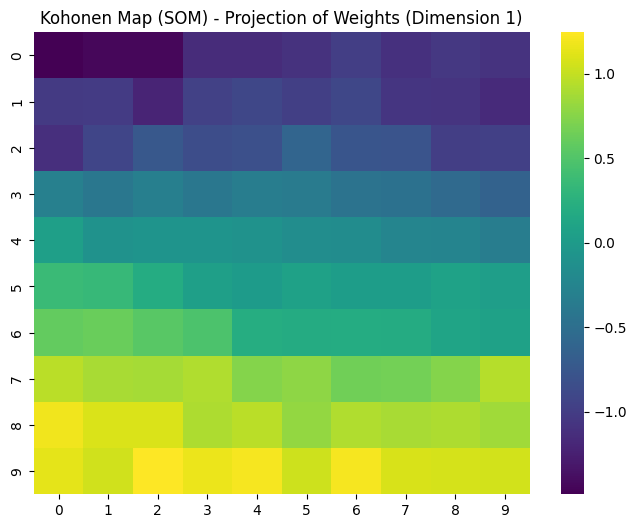

-------- 10000 --------


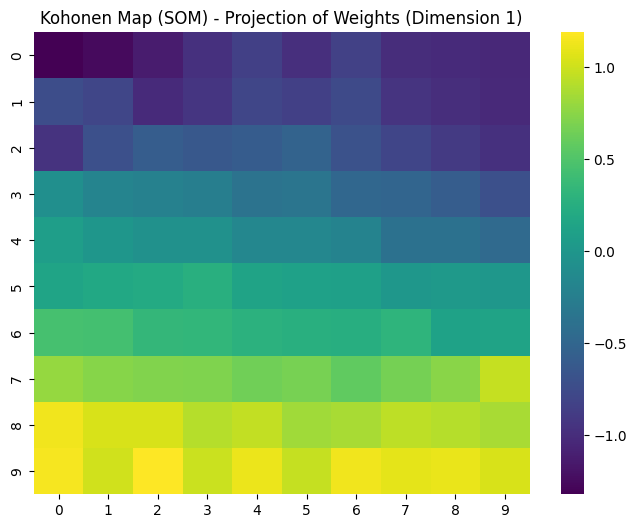

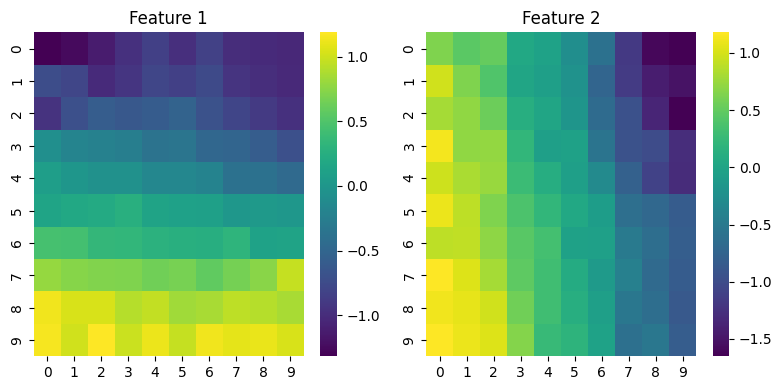

-------- 11000 --------


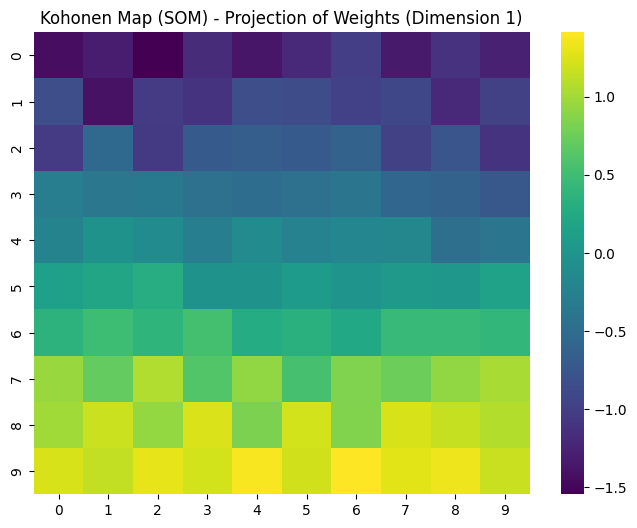

-------- 12000 --------


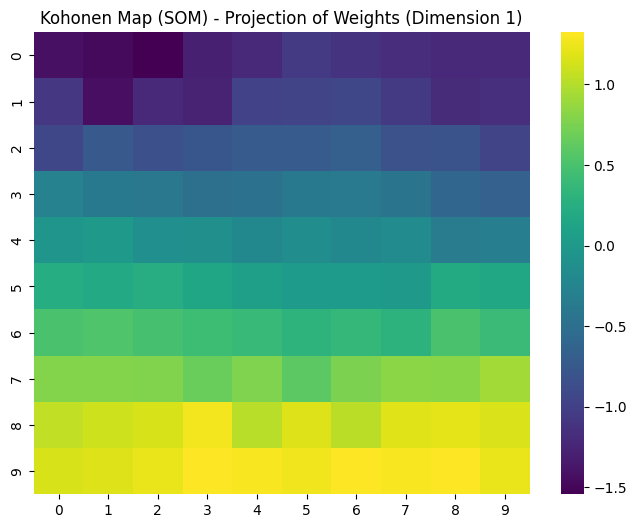

-------- 13000 --------


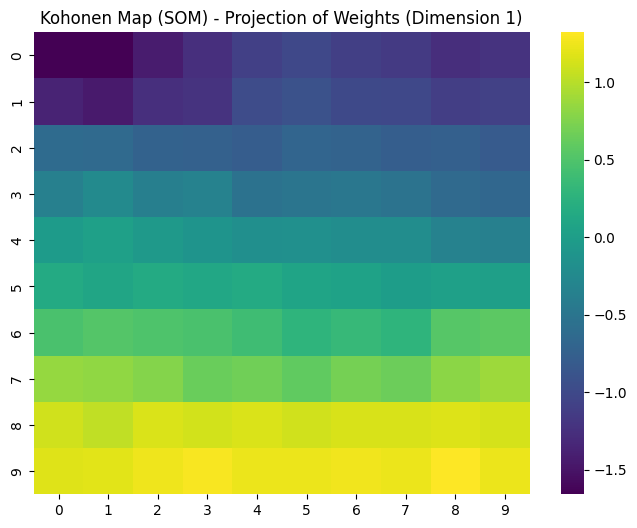

-------- 14000 --------


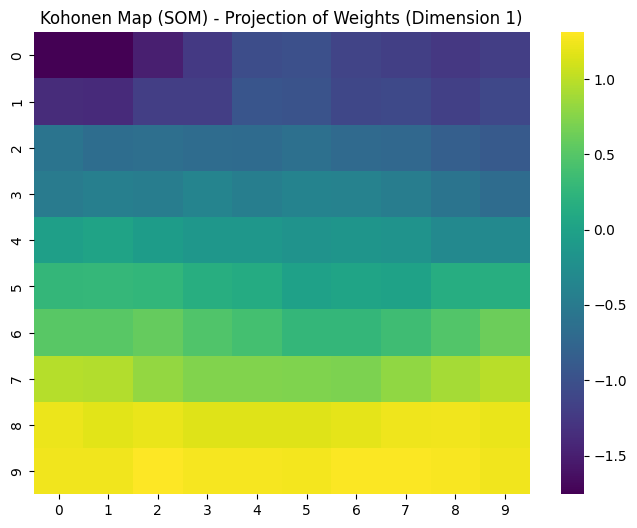

-------- 15000 --------


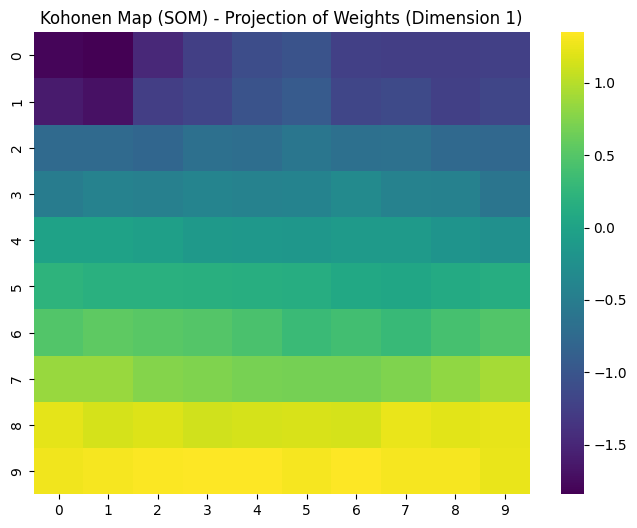

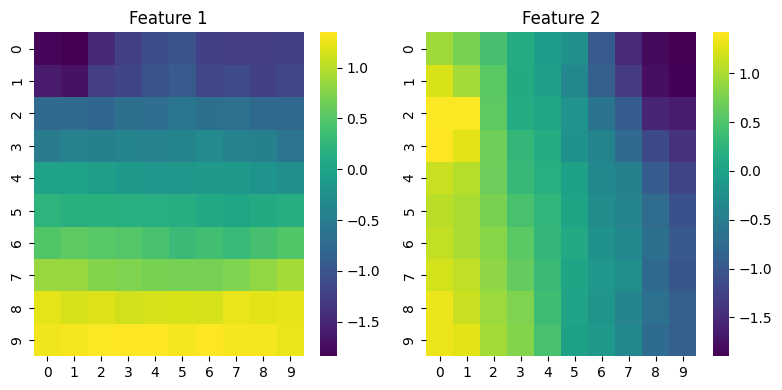

-------- 16000 --------


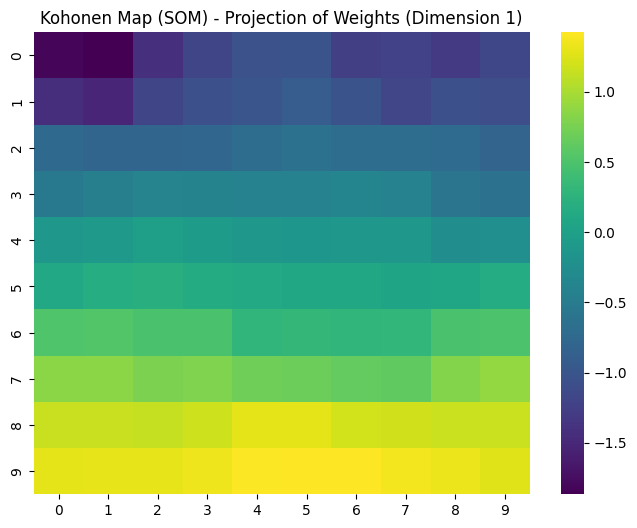

-------- 17000 --------


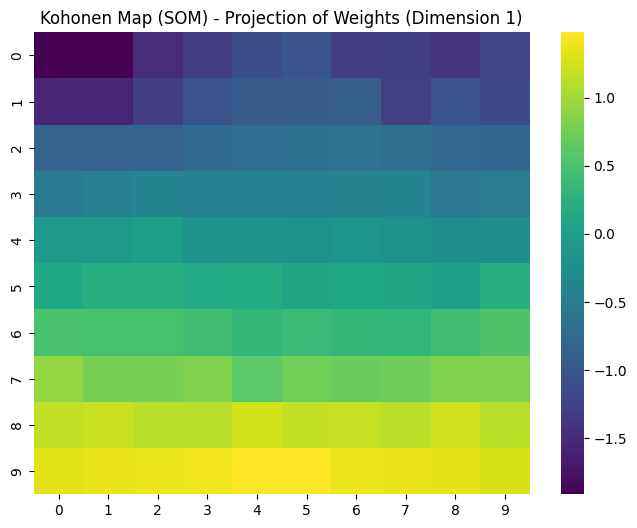

-------- 18000 --------


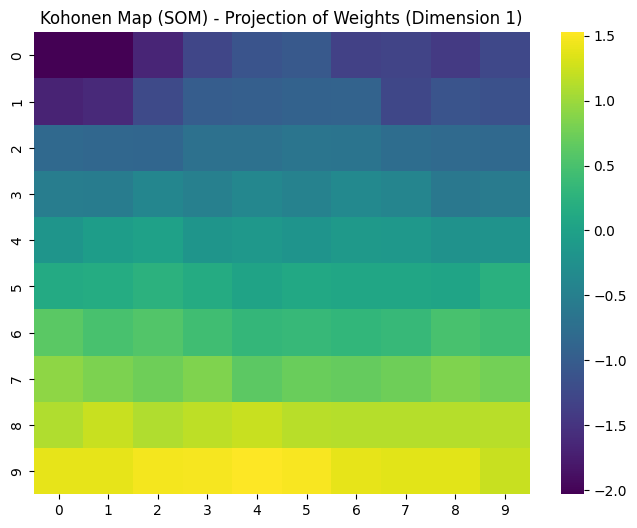

-------- 19000 --------


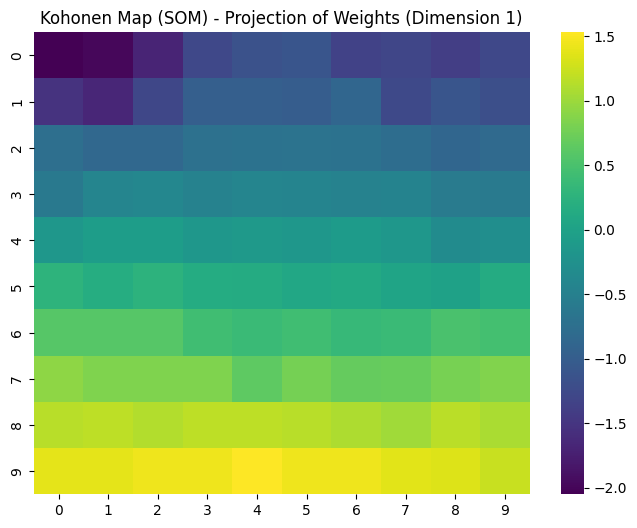

In [277]:
# Training the KSOM with the Mexican Hat function
for iteration in range(n_iterations):
    # Select a random input vector
    input_vector = X_s_curtosis_entropy_train[np.random.randint(0, X_s_curtosis_entropy_train.shape[0])]

    # Find the Best Matching Unit (Best neuron)
    bmu_idx = find_bmu(input_vector, weights_s_curtosis_entropy)

    # Update the weights of the BMU and neighboring neurons
    weights_s_curtosis_entropy = update_weights_mexican_hat(input_vector, bmu_idx, iteration, weights_s_curtosis_entropy, map_width, map_height, learning_rate, time_constant)

    # Gradually reduce the learning rate over iterations
    learning_rate = 0.5 * np.exp(-iteration / n_iterations)
    if iteration%1000==0:
      print("--------",iteration,"--------")
      visualize_som_weights(weights_s_curtosis_entropy)
    if iteration % 5000 == 0:
      visualize_all_som_weights(weights_s_curtosis_entropy)

    # Call the function to visualize the map after training

In [278]:
bmu_to_class3 = build_bmu_class_map(X_s_curtosis_entropy_train, y_s_curtosis_entropy_train, weights_s_curtosis_entropy)
print("BMU to Class Mapping:", bmu_to_class3)

BMU to Class Mapping: {(7, 7): np.int64(0), (4, 8): np.int64(1), (0, 4): np.int64(1), (5, 5): np.int64(0), (0, 5): np.int64(1), (8, 9): np.int64(0), (9, 0): np.int64(0), (9, 6): np.int64(0), (4, 6): np.int64(1), (2, 8): np.int64(1), (5, 3): np.int64(1), (7, 1): np.int64(0), (1, 5): np.int64(1), (5, 0): np.int64(0), (8, 1): np.int64(0), (9, 9): np.int64(0), (5, 1): np.int64(0), (1, 2): np.int64(1), (9, 4): np.int64(0), (0, 2): np.int64(1), (2, 0): np.int64(0), (2, 3): np.int64(1), (3, 9): np.int64(1), (7, 0): np.int64(0), (3, 5): np.int64(1), (4, 0): np.int64(0), (7, 9): np.int64(0), (8, 2): np.int64(0), (2, 7): np.int64(1), (8, 6): np.int64(0), (9, 1): np.int64(0), (1, 8): np.int64(1), (2, 6): np.int64(1), (2, 1): np.int64(0), (7, 6): np.int64(0), (7, 5): np.int64(0), (1, 9): np.int64(1), (9, 5): np.int64(0), (9, 2): np.int64(0), (9, 8): np.int64(0), (3, 3): np.int64(1), (7, 4): np.int64(0), (3, 8): np.int64(1), (8, 5): np.int64(0), (6, 2): np.int64(0), (1, 4): np.int64(1), (1, 7): np.

Sem remover ninguem

In [279]:
df_clean = df.copy()
df_clean_val = df_val.copy()

In [280]:
X_clean_train = df_clean.iloc[:, :-1].values # Features (all columns except the last one)
y_clean_train = df_clean.iloc[:, -1].values  # Labels (the last column)

X_clean_val = df_clean_val.iloc[:, :-1].values # Features (all columns except the last one)
y_clean_val = df_clean_val.iloc[:, -1].values  # Labels (the last column)

X_clean_train = StandardScaler().fit_transform(X_clean_train)
X_clean_val = StandardScaler().fit_transform(X_clean_val)

In [281]:
#### Configurações
# Map and data dimensions
map_width = 10
map_height = 10
n_features = X_clean_train.shape[1]  # 8 features
print("Núnmero de atributos:", n_features)
# Random initialization of neuron weights
weights_clean = np.random.rand(map_width, map_height, n_features)

# Learning parameters
learning_rate = 0.4
n_iterations = 20000
initial_radius = max(map_width, map_height) / 2
time_constant = n_iterations / np.log(initial_radius)

Núnmero de atributos: 4


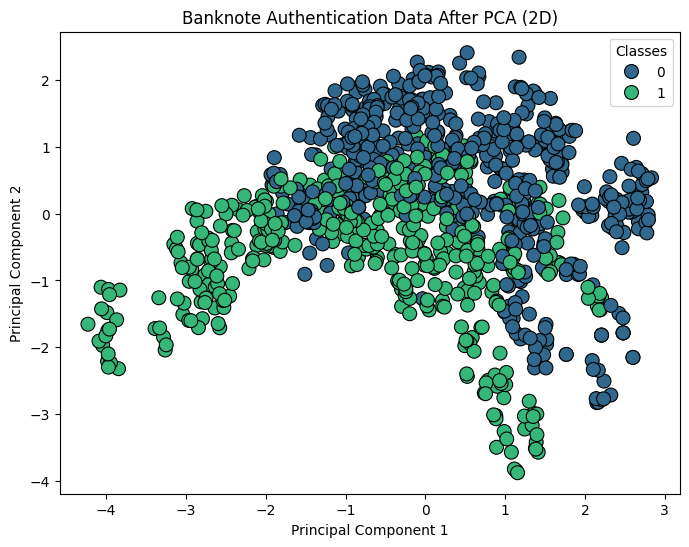

In [282]:
# Call the function to visualize the original data
visualize_data_pca(X_clean_train, y_clean_train)

-------- 0 --------


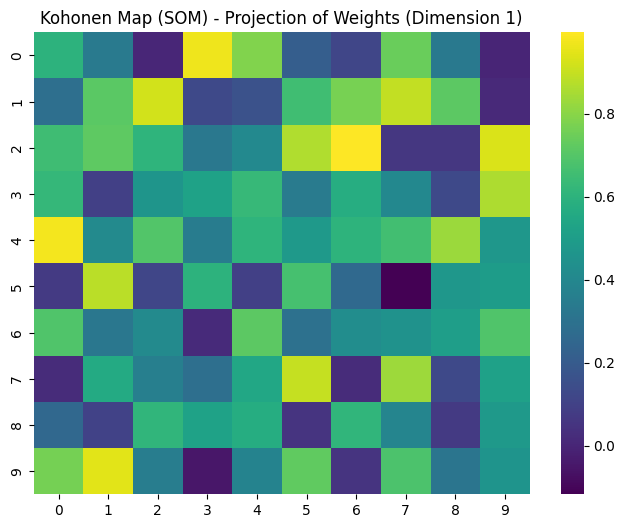

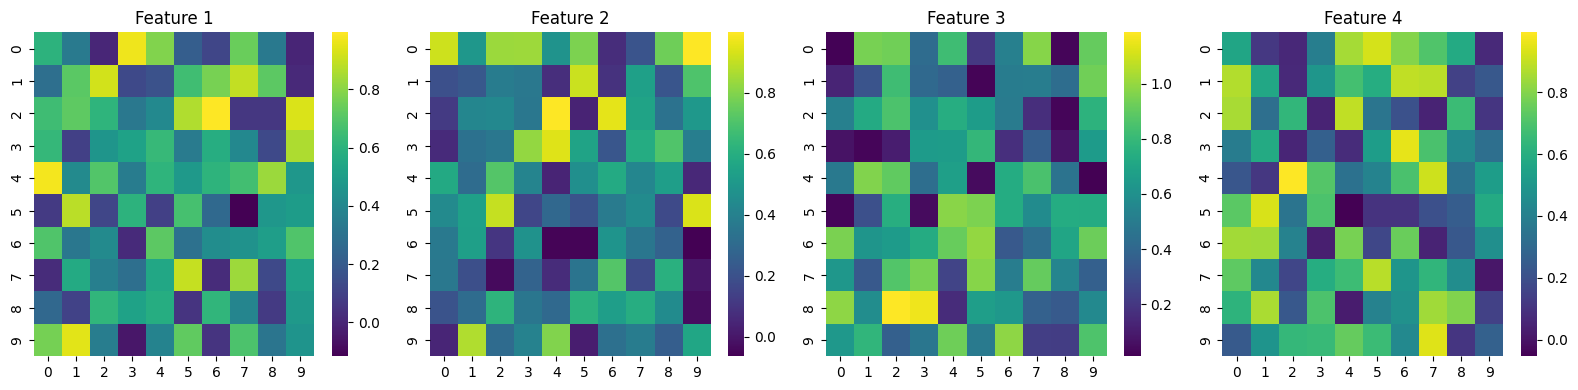

-------- 1000 --------


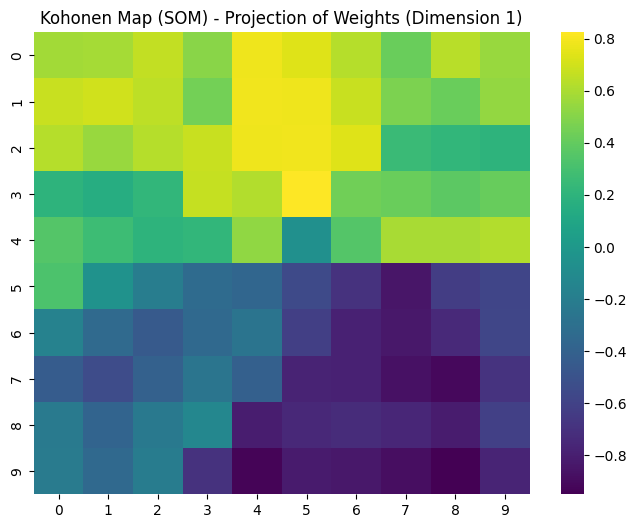

-------- 2000 --------


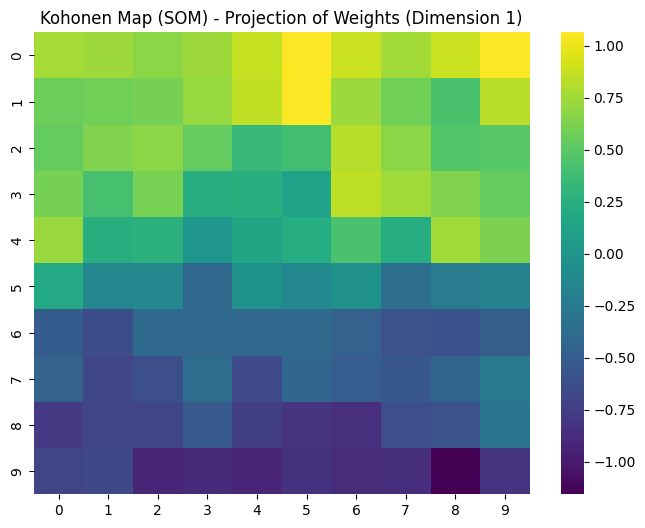

-------- 3000 --------


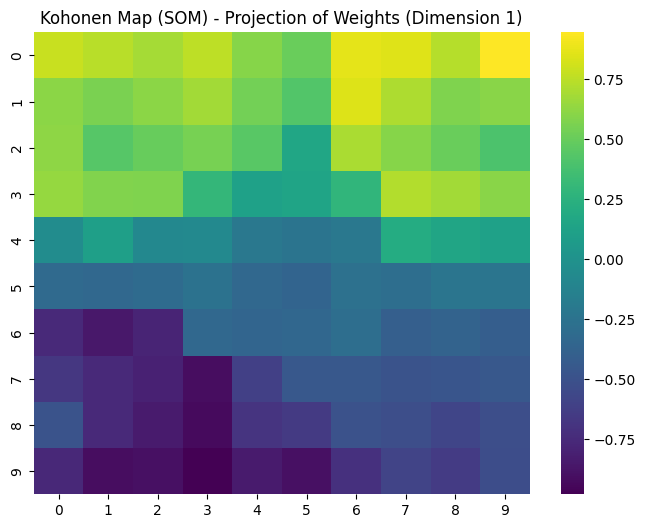

-------- 4000 --------


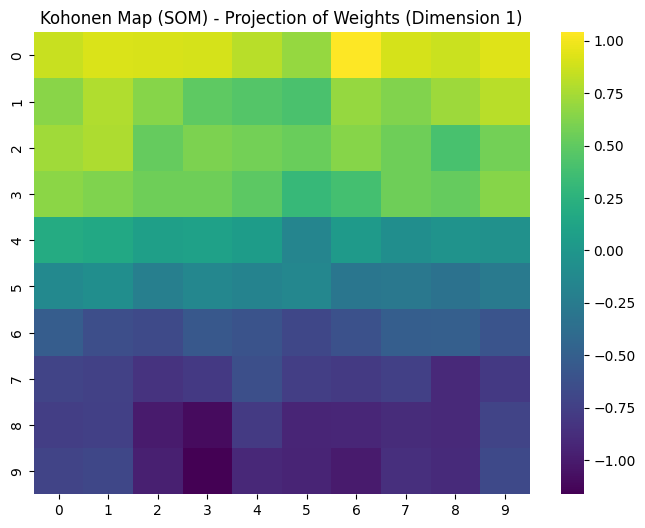

-------- 5000 --------


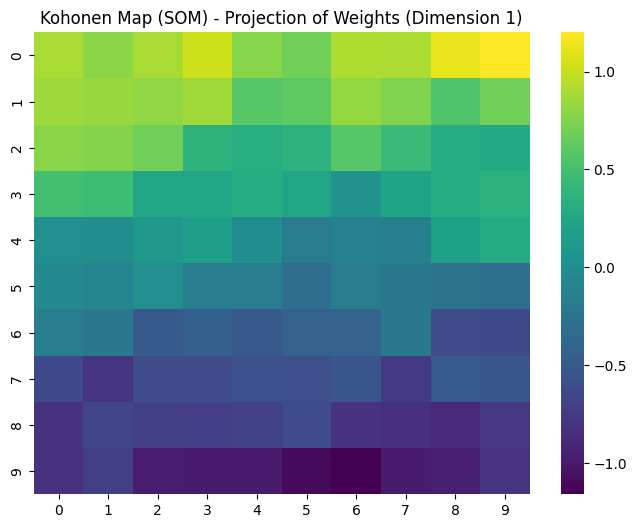

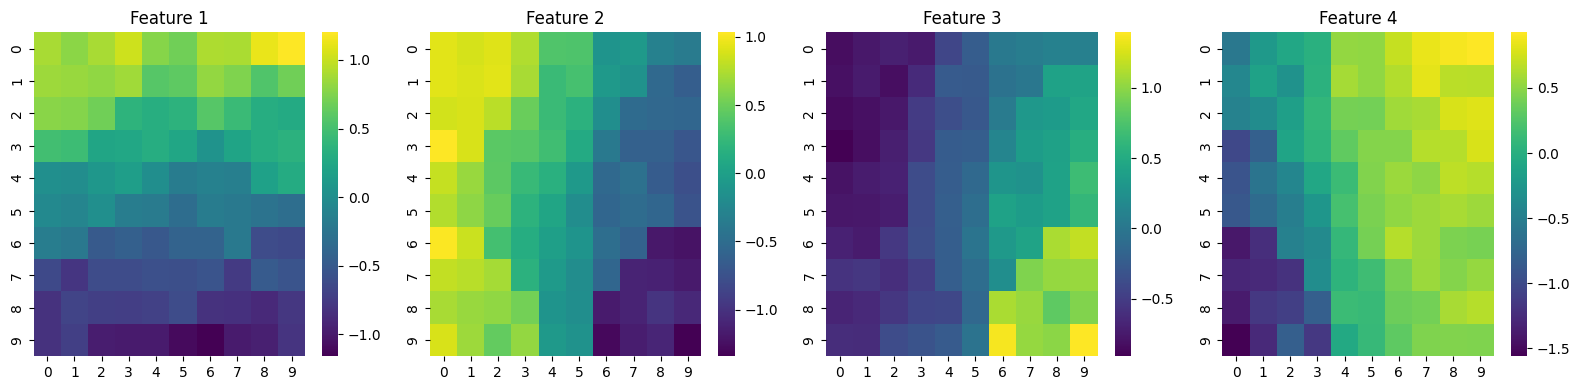

-------- 6000 --------


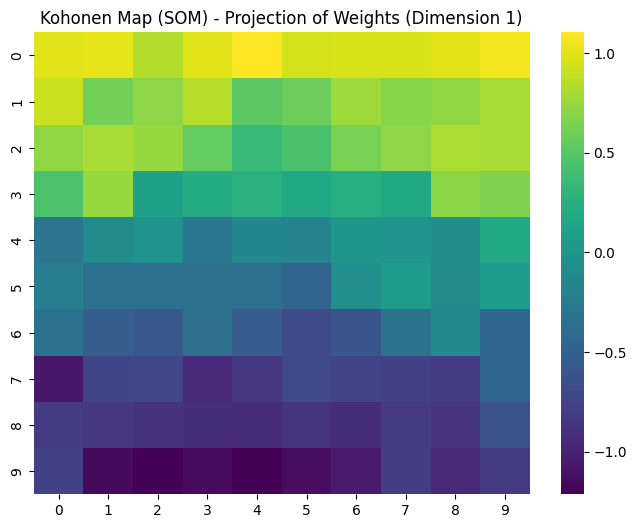

-------- 7000 --------


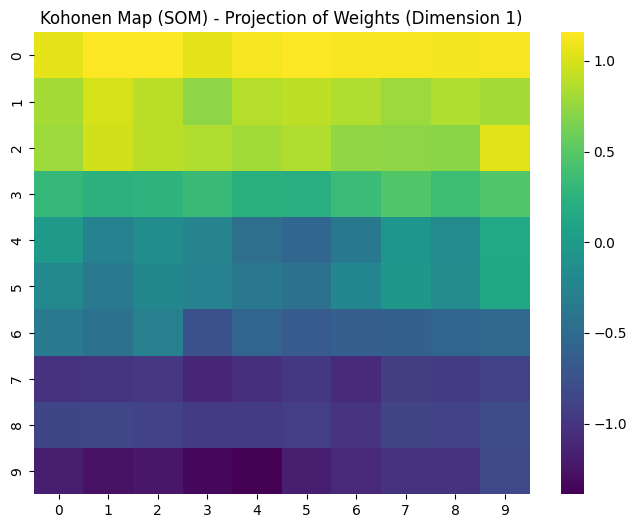

-------- 8000 --------


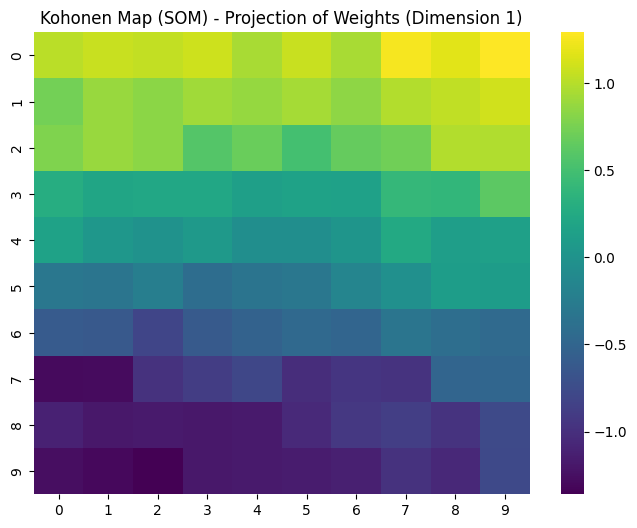

-------- 9000 --------


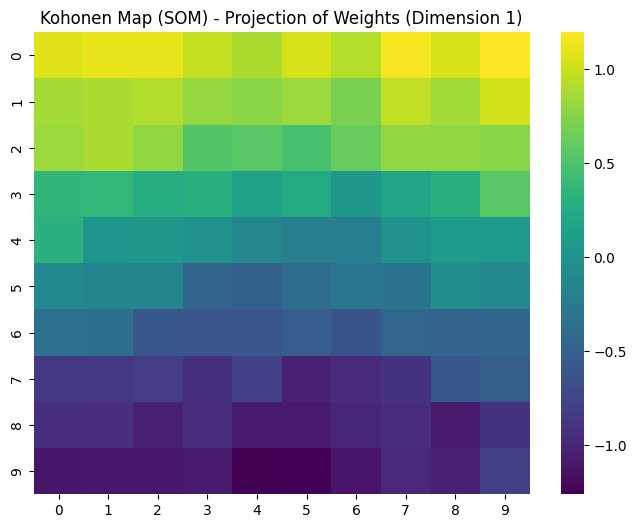

-------- 10000 --------


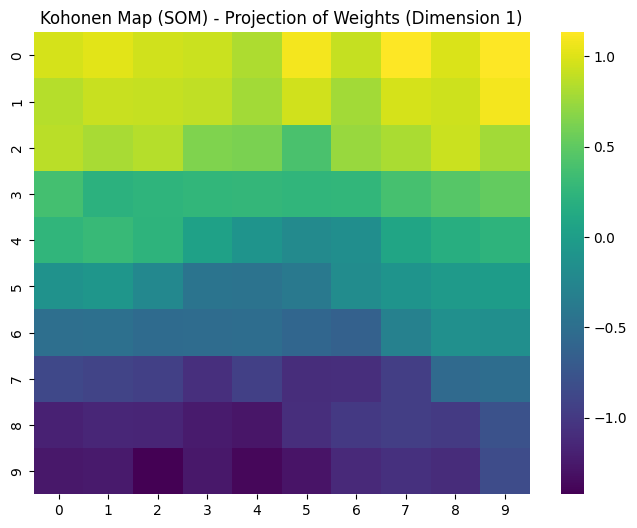

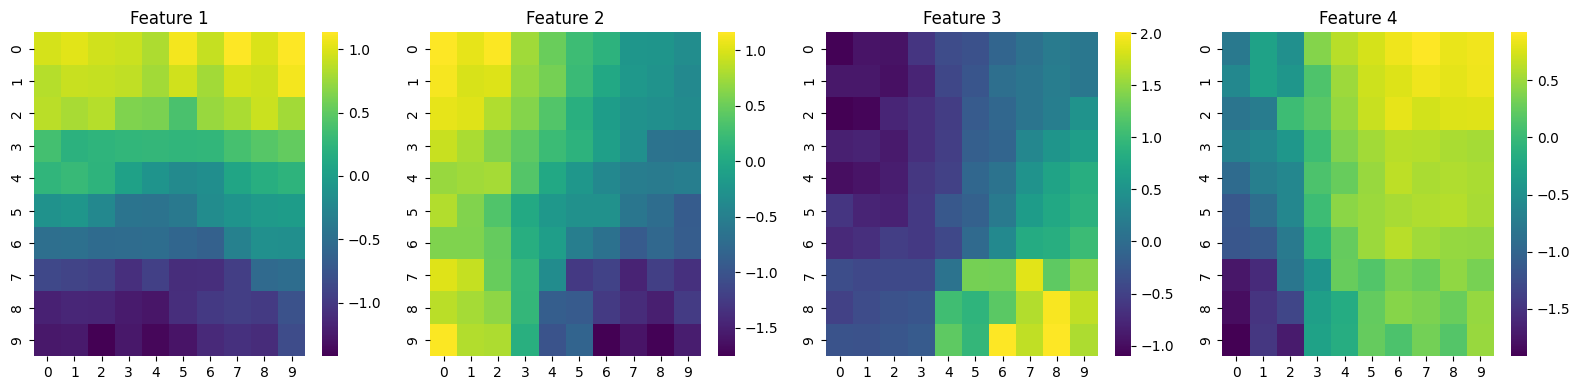

-------- 11000 --------


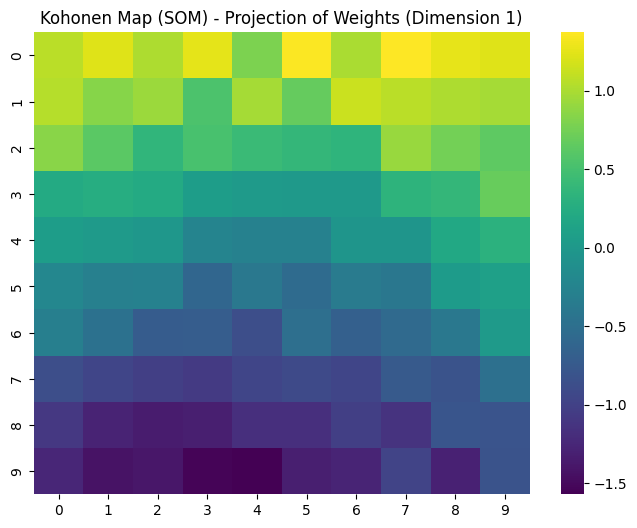

-------- 12000 --------


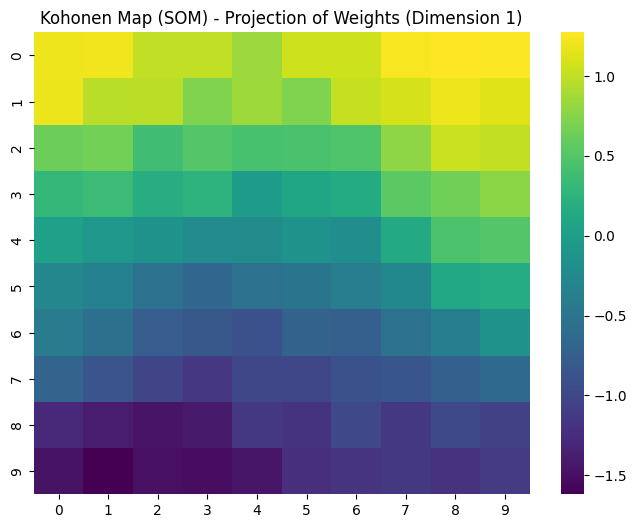

-------- 13000 --------


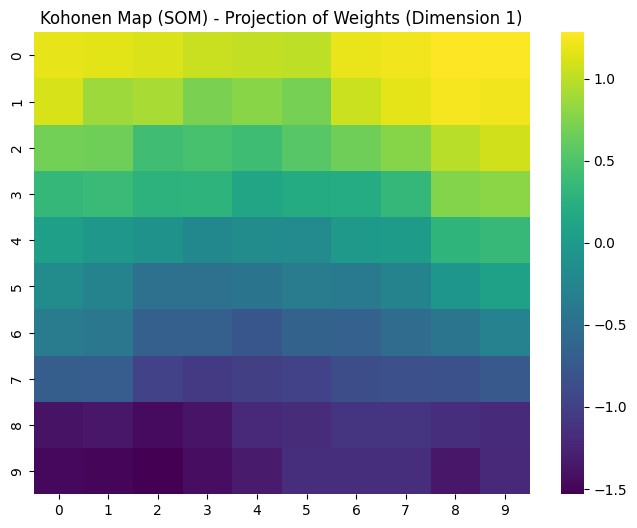

-------- 14000 --------


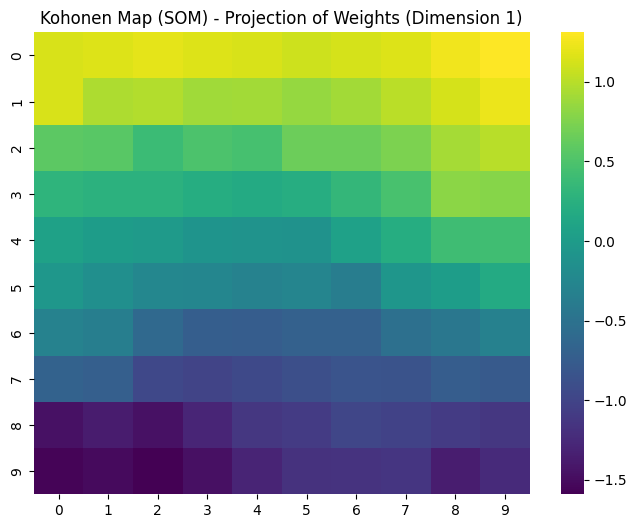

-------- 15000 --------


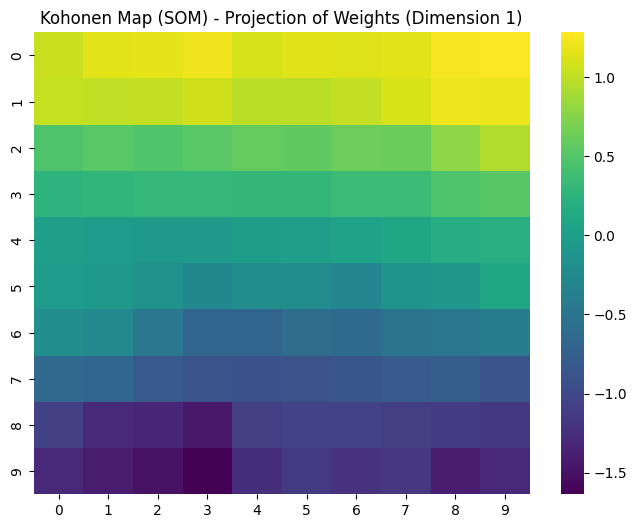

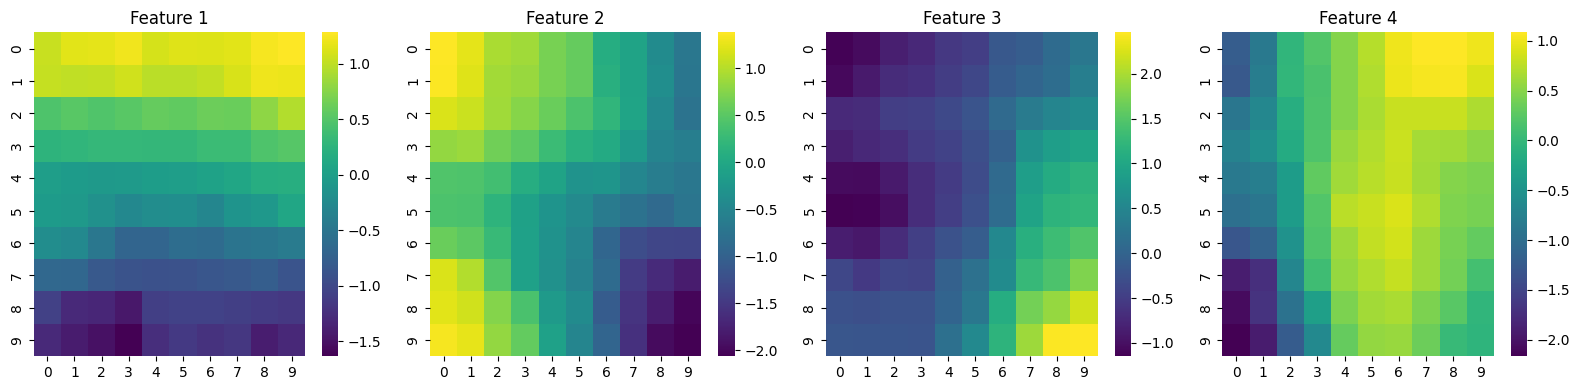

-------- 16000 --------


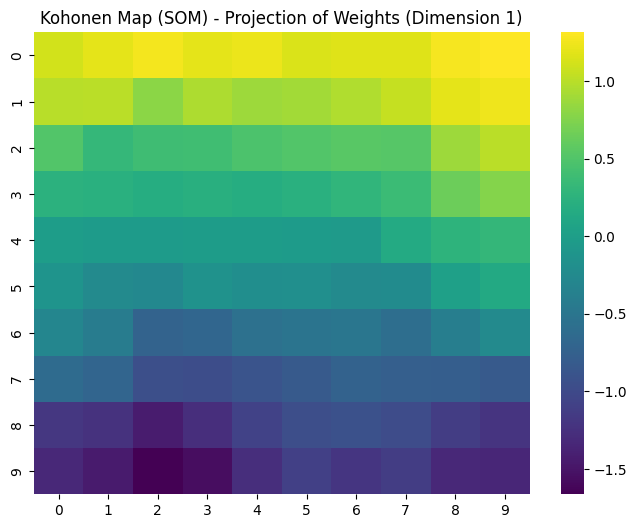

-------- 17000 --------


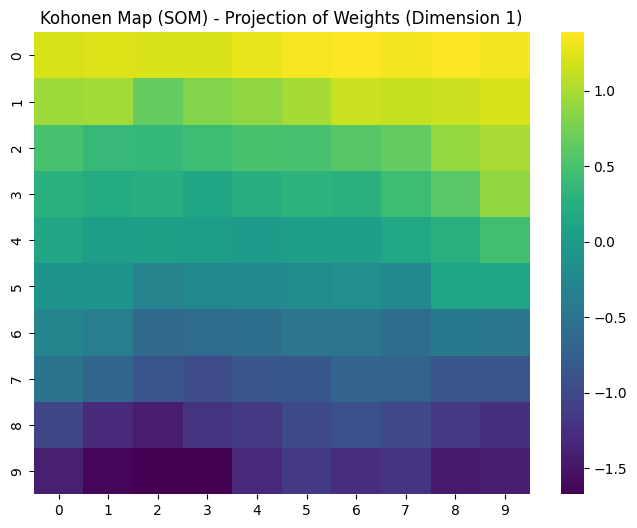

-------- 18000 --------


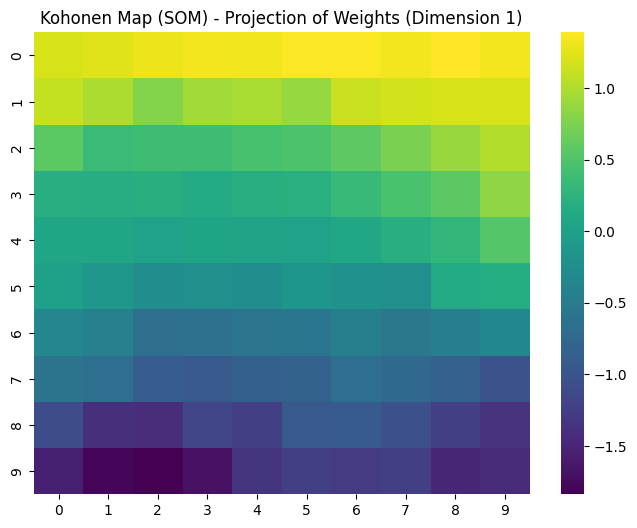

-------- 19000 --------


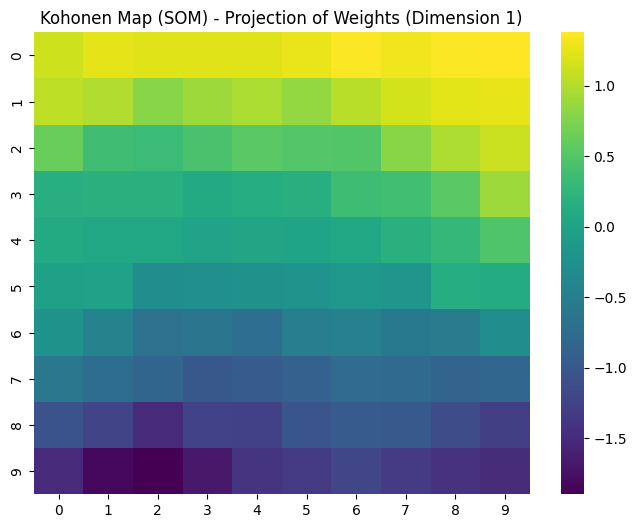

In [283]:
# Training the KSOM with the Mexican Hat function
for iteration in range(n_iterations):
    # Select a random input vector
    input_vector = X_clean_train[np.random.randint(0, X_clean_train.shape[0])]

    # Find the Best Matching Unit (Best neuron)
    bmu_idx = find_bmu(input_vector, weights_clean)

    # Update the weights of the BMU and neighboring neurons
    weights_clean = update_weights_mexican_hat(input_vector, bmu_idx, iteration, weights_clean, map_width, map_height, learning_rate, time_constant)

    # Gradually reduce the learning rate over iterations
    learning_rate = 0.5 * np.exp(-iteration / n_iterations)
    if iteration%1000==0:
      print("--------",iteration,"--------")
      visualize_som_weights(weights_clean)
    if iteration % 5000 == 0:
      visualize_all_som_weights(weights_clean)

In [284]:
bmu_to_class2 = build_bmu_class_map(X_s_curtosis_train, y_s_curtosis_train, weights_s_curtosis)
print("BMU to Class Mapping:", bmu_to_class2)

BMU to Class Mapping: {(2, 7): np.int64(0), (5, 8): np.int64(1), (7, 5): np.int64(1), (4, 5): np.int64(0), (8, 5): np.int64(1), (0, 8): np.int64(0), (0, 0): np.int64(0), (0, 6): np.int64(0), (5, 7): np.int64(1), (7, 8): np.int64(1), (7, 1): np.int64(1), (2, 2): np.int64(0), (7, 6): np.int64(1), (3, 1): np.int64(0), (1, 0): np.int64(0), (3, 2): np.int64(0), (8, 4): np.int64(1), (0, 4): np.int64(0), (9, 4): np.int64(1), (4, 0): np.int64(0), (8, 2): np.int64(1), (6, 9): np.int64(1), (9, 5): np.int64(1), (2, 0): np.int64(0), (6, 4): np.int64(1), (5, 0): np.int64(0), (6, 0): np.int64(0), (1, 9): np.int64(0), (1, 2): np.int64(0), (6, 8): np.int64(1), (0, 7): np.int64(0), (0, 1): np.int64(0), (8, 8): np.int64(1), (6, 6): np.int64(1), (8, 0): np.int64(0), (3, 8): np.int64(0), (2, 6): np.int64(0), (8, 9): np.int64(1), (1, 3): np.int64(0), (0, 3): np.int64(0), (1, 6): np.int64(0), (2, 9): np.int64(0), (7, 2): np.int64(1), (2, 5): np.int64(0), (3, 4): np.int64(0), (7, 4): np.int64(1), (4, 6): np.

## Comparison

In [285]:
def calculate_quantization_error(X, weights):
    """Calculate average distance between data points and their BMUs"""
    total_error = 0
    for i in range(len(X)):
        bmu_idx = find_bmu(X[i], weights)
        bmu_weights = weights[bmu_idx[0], bmu_idx[1]]
        error = euclidean_distance(X[i], bmu_weights)
        total_error += error
    return total_error / len(X)
    
# Compare two SOMs
error_som1 = calculate_quantization_error(X_s_entropy_train, weights_s_entropy)
error_som2 = calculate_quantization_error(X_s_curtosis_train, weights_s_curtosis)
error_som3 = calculate_quantization_error(X_s_curtosis_entropy_train, weights_s_curtosis_entropy)
error_som4 = calculate_quantization_error(X_clean_train, weights_clean)

print(f"SOM 1 Quantization Error: {error_som1:.4f}")
print(f"SOM 2 Quantization Error: {error_som2:.4f}")
print(f"SOM 3 Quantization Error: {error_som3:.4f}")
print(f"SOM 4 Quantization Error: {error_som4:.4f}")

SOM 1 Quantization Error: 0.2743
SOM 2 Quantization Error: 0.3145
SOM 3 Quantization Error: 0.1522
SOM 4 Quantization Error: 0.4345


In [286]:
def calculate_topographic_error(X, weights):
    """Calculate percentage of data points where BMU and 2nd BMU are not neighbors"""
    topographic_errors = 0
    
    for i in range(len(X)):
        # Find BMU and second BMU
        distances = []
        for row in range(map_width):
            for col in range(map_height):
                dist = euclidean_distance(X[i], weights[row, col])
                distances.append((dist, (row, col)))
        
        distances.sort()
        bmu1 = distances[0][1]
        bmu2 = distances[1][1]
        
        # Check if they are neighbors (adjacent cells)
        if abs(bmu1[0] - bmu2[0]) + abs(bmu1[1] - bmu2[1]) > 1:
            topographic_errors += 1
    
    return topographic_errors / len(X)

topo_error1 = calculate_topographic_error(X_s_entropy_train, weights_s_entropy)
topo_error2 = calculate_topographic_error(X_s_curtosis_train, weights_s_curtosis)
topo_error3 = calculate_topographic_error(X_s_curtosis_entropy_train, weights_s_curtosis_entropy)
topo_error4 = calculate_topographic_error(X_clean_train, weights_clean)

print(f"SOM 1 Topographic Error: {topo_error1:.4f}")
print(f"SOM 2 Topographic Error: {topo_error2:.4f}")
print(f"SOM 3 Topographic Error: {topo_error3:.4f}")
print(f"SOM 4 Topographic Error: {topo_error4:.4f}")

SOM 1 Topographic Error: 0.1707
SOM 2 Topographic Error: 0.1220
SOM 3 Topographic Error: 0.1192
SOM 4 Topographic Error: 0.1355


In [287]:
def evaluate_som_classification(X_test, y_test, weights, bmu_to_class):
    """Evaluate classification accuracy on test data"""
    correct_predictions = 0
    
    for i in range(len(X_test)):
        bmu = infer_som(X_test[i], weights)
        predicted_class = bmu_to_class.get(tuple(bmu), -1)  # -1 if BMU not in training
        
        if predicted_class == y_test[i]:
            correct_predictions += 1
    
    return correct_predictions / len(X_test)

# Build class maps for both SOMs
bmu_to_class1 = build_bmu_class_map(X_s_entropy_train, y_s_entropy_train, weights_s_entropy)
bmu_to_class2 = build_bmu_class_map(X_s_curtosis_train, y_s_curtosis_train, weights_s_curtosis)
bmu_to_class3 = build_bmu_class_map(X_s_curtosis_entropy_train, y_s_curtosis_entropy_train, weights_s_curtosis_entropy)
bmu_to_class4 = build_bmu_class_map(X_clean_train, y_clean_train, weights_clean)

# Evaluate on test data
accuracy1 = evaluate_som_classification(X_s_entropy_val, y_s_entropy_val, weights_s_entropy, bmu_to_class1)
accuracy2 = evaluate_som_classification(X_s_curtosis_val, y_s_curtosis_val, weights_s_curtosis, bmu_to_class2)
accuracy3 = evaluate_som_classification(X_s_curtosis_entropy_val, y_s_curtosis_entropy_val, weights_s_curtosis_entropy, bmu_to_class3)
accuracy4 = evaluate_som_classification(X_clean_val, y_clean_val, weights_clean, bmu_to_class4)

print(f"SOM 1 Classification Accuracy: {accuracy1:.4f}")
print(f"SOM 2 Classification Accuracy: {accuracy2:.4f}")
print(f"SOM 3 Classification Accuracy: {accuracy3:.4f}")
print(f"SOM 4 Classification Accuracy: {accuracy4:.4f}")

SOM 1 Classification Accuracy: 1.0000
SOM 2 Classification Accuracy: 0.9694
SOM 3 Classification Accuracy: 0.9337
SOM 4 Classification Accuracy: 0.9847


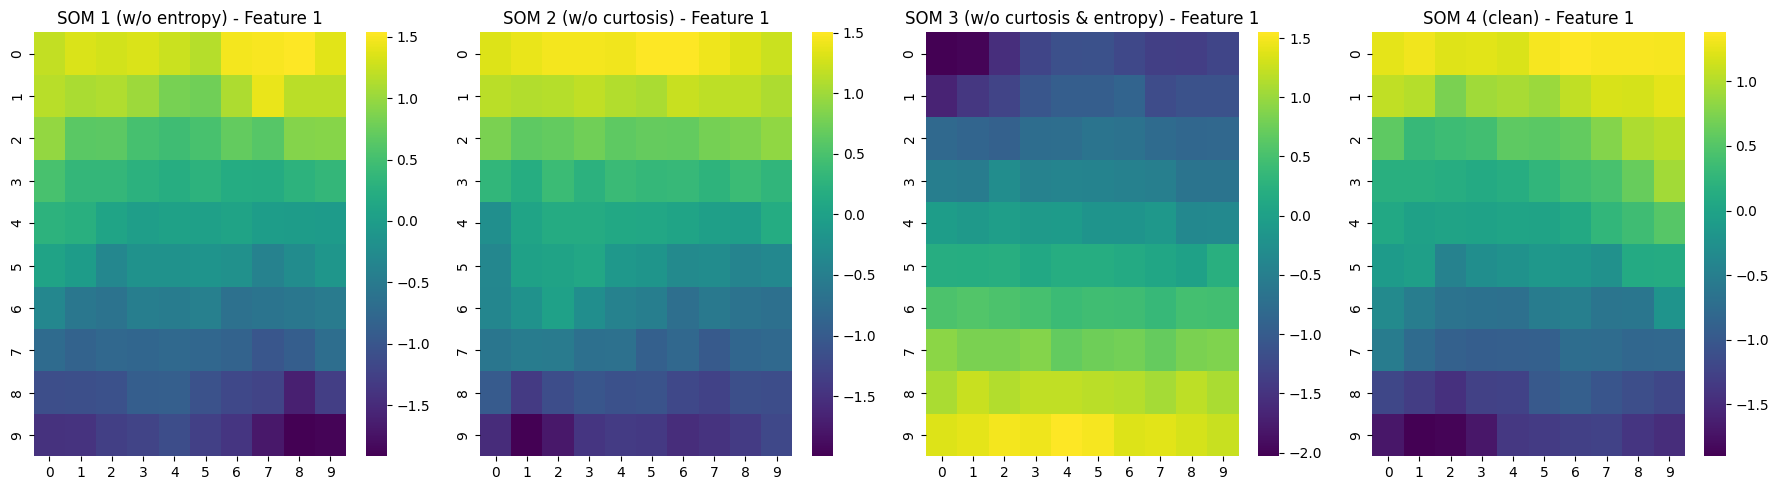

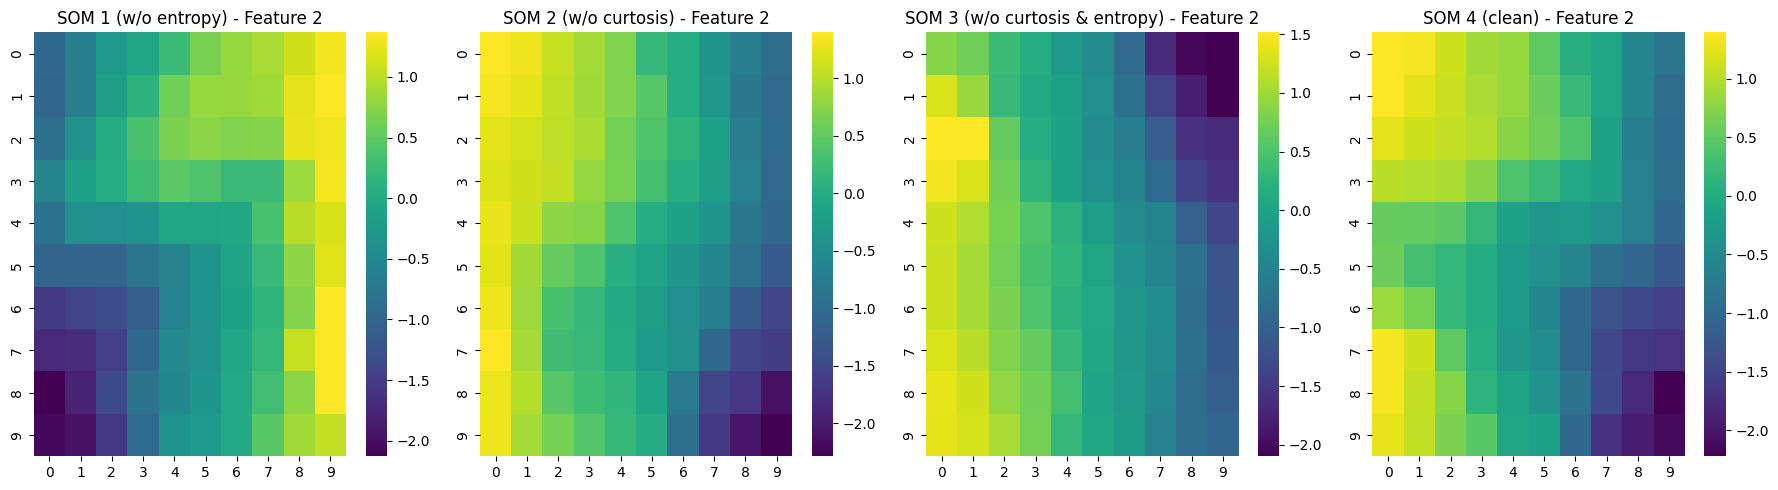

In [288]:
def compare_som_weights(weights1, weights2, weights3, weights4, feature_idx=0):
    """Compare weight patterns for a specific feature across three SOMs"""
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 5))
    
    # SOM 1 (without entropy)
    sns.heatmap(weights1[:, :, feature_idx], ax=ax1, cmap="viridis", cbar=True)
    ax1.set_title(f"SOM 1 (w/o entropy) - Feature {feature_idx+1}")
    
    # SOM 2 (without curtosis)
    sns.heatmap(weights2[:, :, feature_idx], ax=ax2, cmap="viridis", cbar=True)
    ax2.set_title(f"SOM 2 (w/o curtosis) - Feature {feature_idx+1}")
    
    # SOM 3 (without curtosis and entropy)
    sns.heatmap(weights3[:, :, feature_idx], ax=ax3, cmap="viridis", cbar=True)
    ax3.set_title(f"SOM 3 (w/o curtosis & entropy) - Feature {feature_idx+1}")
    
    # SOM 4 (clean)
    sns.heatmap(weights4[:, :, feature_idx], ax=ax4, cmap="viridis", cbar=True)
    ax4.set_title(f"SOM 4 (clean) - Feature {feature_idx+1}")
    
    plt.tight_layout()
    plt.show()

# Compare all available features for the three SOMs
for i in range(min(weights_s_entropy.shape[2], weights_s_curtosis.shape[2], weights_s_curtosis_entropy.shape[2])):
    compare_som_weights(weights_s_entropy, weights_s_curtosis, weights_s_curtosis_entropy, weights_clean,i)


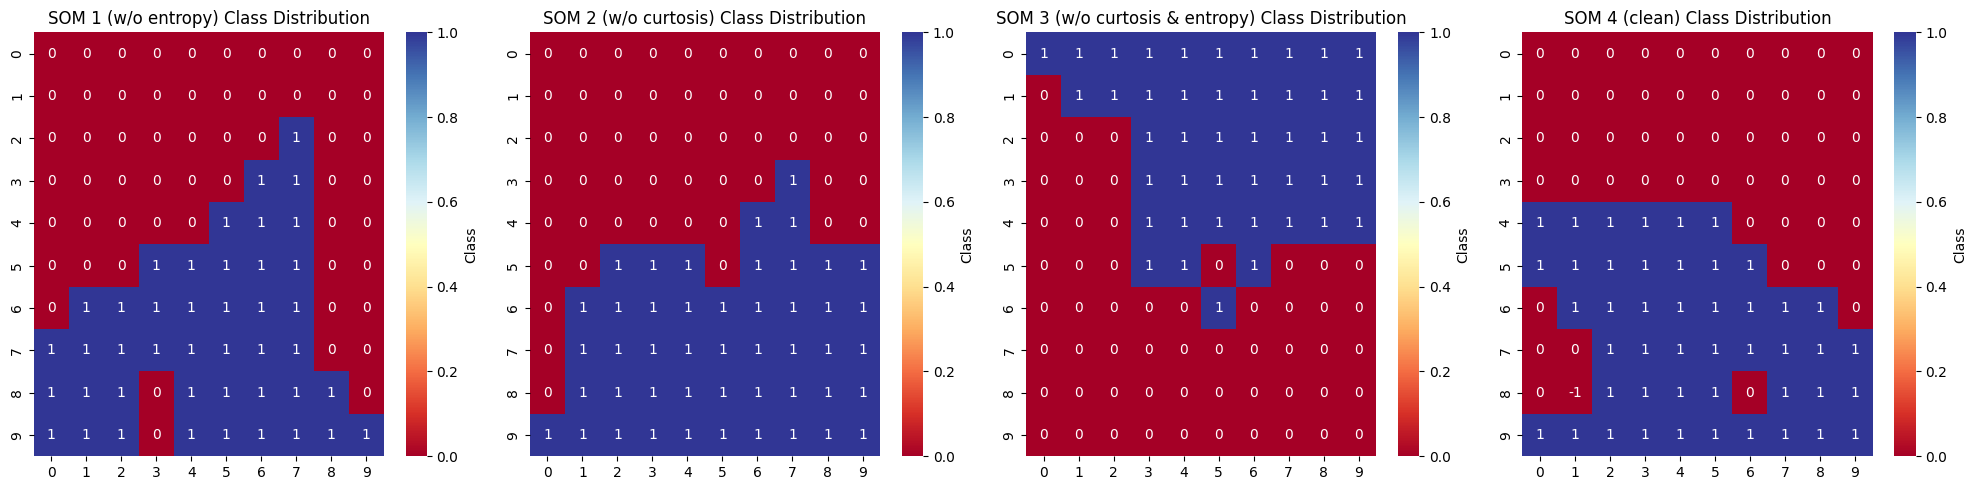

In [289]:
def visualize_class_distribution_comparison(bmu_to_class1, bmu_to_class2, bmu_to_class3, bmu_to_class4):
    """Compare class distributions between four SOMs"""
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
    
    # Create class grids
    class_grid1 = np.full((map_width, map_height), -1)
    class_grid2 = np.full((map_width, map_height), -1)
    class_grid3 = np.full((map_width, map_height), -1)
    class_grid4 = np.full((map_width, map_height), -1)
    
    for (i, j), class_label in bmu_to_class1.items():
        class_grid1[i, j] = class_label
    
    for (i, j), class_label in bmu_to_class2.items():
        class_grid2[i, j] = class_label
        
    for (i, j), class_label in bmu_to_class3.items():
        class_grid3[i, j] = class_label
        
    for (i, j), class_label in bmu_to_class4.items():
        class_grid4[i, j] = class_label
    
    # Plot
    sns.heatmap(class_grid1, ax=ax1, cmap="RdYlBu", vmin=0, vmax=1, 
                annot=True, fmt='.0f', cbar_kws={'label': 'Class'})
    ax1.set_title("SOM 1 (w/o entropy) Class Distribution")
    
    sns.heatmap(class_grid2, ax=ax2, cmap="RdYlBu", vmin=0, vmax=1,
                annot=True, fmt='.0f', cbar_kws={'label': 'Class'})
    ax2.set_title("SOM 2 (w/o curtosis) Class Distribution")
    
    sns.heatmap(class_grid3, ax=ax3, cmap="RdYlBu", vmin=0, vmax=1,
                annot=True, fmt='.0f', cbar_kws={'label': 'Class'})
    ax3.set_title("SOM 3 (w/o curtosis & entropy) Class Distribution")
    
    sns.heatmap(class_grid4, ax=ax4, cmap="RdYlBu", vmin=0, vmax=1,
                annot=True, fmt='.0f', cbar_kws={'label': 'Class'})
    ax4.set_title("SOM 4 (clean) Class Distribution")
    
    plt.tight_layout()
    plt.show()

visualize_class_distribution_comparison(bmu_to_class1, bmu_to_class2, bmu_to_class3, bmu_to_class4)

In [290]:
def comprehensive_som_comparison_four(X_train_list, y_train_list, X_val_list, y_val_list, 
                                     weights_list, names=["SOM 1", "SOM 2", "SOM 3", "SOM 4"]):
    """Comprehensive comparison of four SOMs"""
    print(f"=== SOM Comparison: {names[0]} vs {names[1]} vs {names[2]} vs {names[3]} ===\n")
    
    # Quantization Error
    qe_list = []
    for i, (X_train, weights) in enumerate(zip(X_train_list, weights_list)):
        qe = calculate_quantization_error(X_train, weights)
        qe_list.append(qe)
        print(f"Quantization Error {names[i]}: {qe:.4f}")
    
    best_qe_idx = qe_list.index(min(qe_list))
    print(f"  Winner: {names[best_qe_idx]} (lower is better)\n")
    
    # Topographic Error
    te_list = []
    for i, (X_train, weights) in enumerate(zip(X_train_list, weights_list)):
        te = calculate_topographic_error(X_train, weights)
        te_list.append(te)
        print(f"Topographic Error {names[i]}: {te:.4f}")
    
    best_te_idx = te_list.index(min(te_list))
    print(f"  Winner: {names[best_te_idx]} (lower is better)\n")
    
    # Classification Accuracy
    acc_list = []
    for i, (X_train, y_train, X_val, y_val, weights) in enumerate(zip(X_train_list, y_train_list, X_val_list, y_val_list, weights_list)):
        bmu_to_class = build_bmu_class_map(X_train, y_train, weights)
        acc = evaluate_som_classification(X_val, y_val, weights, bmu_to_class)
        acc_list.append(acc)
        print(f"Classification Accuracy {names[i]}: {acc:.4f}")
    
    best_acc_idx = acc_list.index(max(acc_list))
    print(f"  Winner: {names[best_acc_idx]} (higher is better)")

# Usage
comprehensive_som_comparison_four(
    [X_s_entropy_train, X_s_curtosis_train, X_s_curtosis_entropy_train, X_clean_train],
    [y_s_entropy_train, y_s_curtosis_train, y_s_curtosis_entropy_train, y_clean_train],
    [X_s_entropy_val, X_s_curtosis_val, X_s_curtosis_entropy_val, X_clean_val],
    [y_s_entropy_val, y_s_curtosis_val, y_s_curtosis_entropy_val, y_clean_val],
    [weights_s_entropy, weights_s_curtosis, weights_s_curtosis_entropy, weights_clean],
    ["SOM w/o entropy", "SOM w/o curtosis", "SOM w/o curtosis & entropy", "SOM clean"]
)

=== SOM Comparison: SOM w/o entropy vs SOM w/o curtosis vs SOM w/o curtosis & entropy vs SOM clean ===

Quantization Error SOM w/o entropy: 0.2743
Quantization Error SOM w/o curtosis: 0.3145
Quantization Error SOM w/o curtosis & entropy: 0.1522
Quantization Error SOM clean: 0.4345
  Winner: SOM w/o curtosis & entropy (lower is better)

Topographic Error SOM w/o entropy: 0.1707
Topographic Error SOM w/o curtosis: 0.1220
Topographic Error SOM w/o curtosis & entropy: 0.1192
Topographic Error SOM clean: 0.1355
  Winner: SOM w/o curtosis & entropy (lower is better)

Classification Accuracy SOM w/o entropy: 1.0000
Classification Accuracy SOM w/o curtosis: 0.9694
Classification Accuracy SOM w/o curtosis & entropy: 0.9337
Classification Accuracy SOM clean: 0.9847
  Winner: SOM w/o entropy (higher is better)


In [291]:
# Visualize the map with multiple BMUs
def visualize_bmu_multiple(bmu_indices, weights, sample_classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(weights[:, :, 0], cmap="viridis", annot=False, cbar=True)
    plt.title("Kohonen Map (SOM) with BMUs for Multiple Samples")

    # Add markers for each BMU
    for idx, bmu_idx in enumerate(bmu_indices):
        #plt.scatter(bmu_idx[1] + 0.5, bmu_idx[0] + 0.5, s=200, c='red', marker='X')
        plt.text(bmu_idx[1] + 0.5, bmu_idx[0] + 0.5, f"C: {sample_classes[idx]}", color='white', fontsize=12, ha='center', va='center')

    plt.show()

def test_inference2(X, y, weights, bmu_to_class):
    bmu_indices = []
    sample_classes = []
    predicted_classes = []

    for idx in range(len(X)):
        new_data = X[idx]
        real_class = y[idx]

        bmu_idx = infer_som(new_data, weights)
        pred_class = bmu_to_class.get(tuple(bmu_idx), -1)  # -1 se BMU nunca foi ativado antes

        bmu_indices.append(bmu_idx)
        sample_classes.append(real_class)
        predicted_classes.append(pred_class)

    # Visualizar (opcional)
    visualize_bmu_multiple(bmu_indices, weights, sample_classes)

    # Calcular acurácia (ignorando casos -1 se quiser)
    valid_idx = [i for i in range(len(predicted_classes)) if predicted_classes[i] != -1]
    if valid_idx:
        acc = accuracy_score(np.array(y)[valid_idx], np.array(predicted_classes)[valid_idx])
        print("Accuracy:", acc)
    else:
        print("Nenhum BMU conhecido foi ativado.")

    return predicted_classes

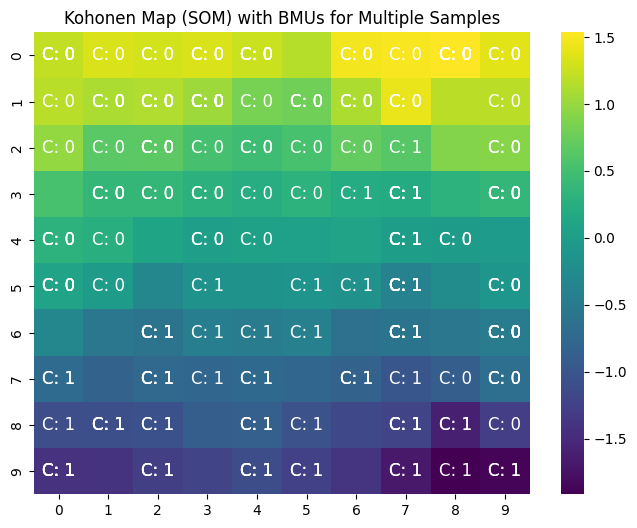

Accuracy: 1.0


In [292]:
predicted1 = test_inference2(X_s_entropy_val, y_s_entropy_val, weights_s_entropy, bmu_to_class1)

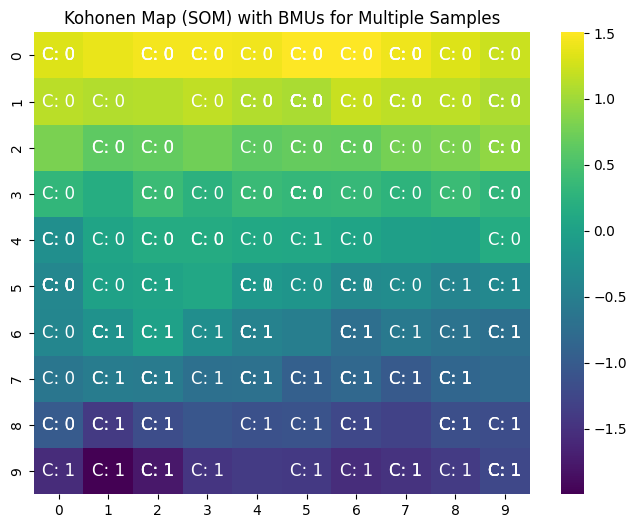

Accuracy: 0.9693877551020408


In [293]:
predicted2 = test_inference2(X_s_curtosis_val, y_s_curtosis_val, weights_s_curtosis, bmu_to_class2)

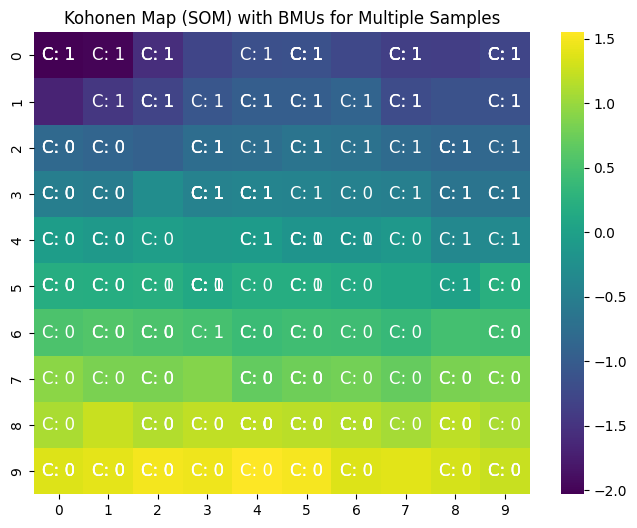

Accuracy: 0.9336734693877551


In [294]:
predicted3 = test_inference2(X_s_curtosis_entropy_val, y_s_curtosis_entropy_val, weights_s_curtosis_entropy, bmu_to_class3)

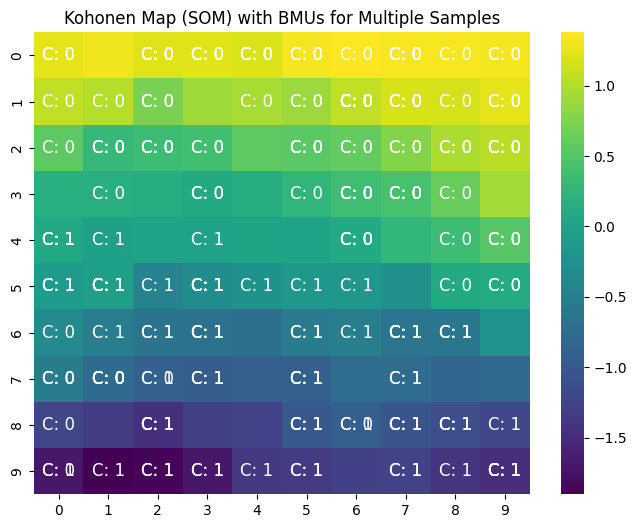

Accuracy: 0.9846938775510204


In [295]:
predicted4 = test_inference2(X_clean_val, y_clean_val, weights_clean, bmu_to_class4)

In [ ]:
# Convert weights_s_entropy to a format suitable for CSV and save
weights_s_entropy_flat = weights_s_entropy.reshape(-1, weights_s_entropy.shape[-1])
weights_s_entropy_df = pd.DataFrame(weights_s_entropy_flat, 
                                   columns=[f'feature_{i+1}' for i in range(weights_s_entropy.shape[-1])])
weights_s_entropy_df['neuron_row'] = np.repeat(range(map_width), map_height)
weights_s_entropy_df['neuron_col'] = np.tile(range(map_height), map_width)

# Reorder columns to have position first
weights_s_entropy_df = weights_s_entropy_df[['neuron_row', 'neuron_col'] + [f'feature_{i+1}' for i in range(weights_s_entropy.shape[-1])]]

weights_s_entropy_df.to_csv("../dataset/sample-data/weights_s_entropy.csv", index=False)
print("Weights saved to weights_s_entropy.csv")
print(f"Shape: {weights_s_entropy_df.shape}")

Weights saved to weights_s_entropy.csv
Shape: (100, 5)


In [ ]:
# Load weights from CSV file
weights_loaded_df = pd.read_csv("../dataset/sample-data/weights_s_entropy-100.csv")

# Extract the dimensions from the loaded data
n_rows = weights_loaded_df['neuron_row'].max() + 1
n_cols = weights_loaded_df['neuron_col'].max() + 1
n_features = len([col for col in weights_loaded_df.columns if col.startswith('feature_')])

# Initialize the weights array
weights_loaded = np.zeros((n_rows, n_cols, n_features))

# Fill the weights array from the DataFrame
for idx, row in weights_loaded_df.iterrows():
    neuron_row = int(row['neuron_row'])
    neuron_col = int(row['neuron_col'])
    
    # Extract feature values
    for f in range(n_features):
        weights_loaded[neuron_row, neuron_col, f] = row[f'feature_{f+1}']

print(f"Loaded weights shape: {weights_loaded.shape}")
print("Weights loaded successfully from CSV")

Usando o modelo escolhido (sem entropy) para prever a base de teste

Test data shape: (69, 3)
Test labels shape: (69,)

=== SOM WITHOUT ENTROPY - TEST RESULTS ===
Test Quantization Error: 0.2906
Test Topographic Error: 0.2319
Test Classification Accuracy: 1.0000


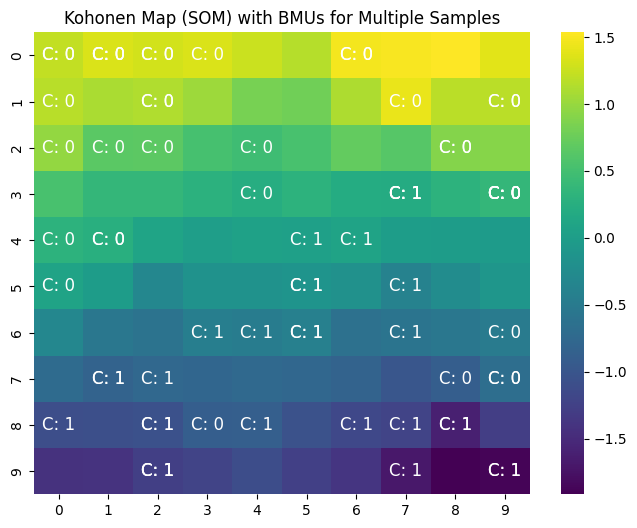

Accuracy: 1.0

Correct predictions: 69
Total valid predictions: 69
Unknown BMUs (not seen in training): 0
Total test samples: 69

Test data class distribution:
  Class 0: 38 samples (55.1%)
  Class 1: 31 samples (44.9%)
Class 0 accuracy: 38/38 (100.0%)
Class 1 accuracy: 31/31 (100.0%)


In [297]:
# Load test data
test_data = pd.read_csv("../dataset/sample-data/banknote_test_complete.csv")

# Remove entropy column to match the model
test_data_s_entropy = test_data.copy().drop(columns=["entropy"])

# Extract features and labels
X_test_s_entropy = test_data_s_entropy.iloc[:, :-1].values
y_test_s_entropy = test_data_s_entropy.iloc[:, -1].values

# Standardize test data (using same scaler as training)
X_test_s_entropy_scaled = StandardScaler().fit_transform(X_test_s_entropy)

print(f"Test data shape: {X_test_s_entropy.shape}")
print(f"Test labels shape: {y_test_s_entropy.shape}")

# Evaluate the SOM on test data
test_accuracy = evaluate_som_classification(X_test_s_entropy_scaled, y_test_s_entropy, weights_s_entropy, bmu_to_class1)

# Calculate test metrics
test_qe = calculate_quantization_error(X_test_s_entropy_scaled, weights_s_entropy)
test_te = calculate_topographic_error(X_test_s_entropy_scaled, weights_s_entropy)

print("\n=== SOM WITHOUT ENTROPY - TEST RESULTS ===")
print(f"Test Quantization Error: {test_qe:.4f}")
print(f"Test Topographic Error: {test_te:.4f}")
print(f"Test Classification Accuracy: {test_accuracy:.4f}")

# Detailed predictions
predicted_test = test_inference2(X_test_s_entropy_scaled, y_test_s_entropy, weights_s_entropy, bmu_to_class1)

# Calculate confusion matrix-like statistics
correct_predictions = sum(1 for i in range(len(y_test_s_entropy)) if predicted_test[i] == y_test_s_entropy[i] and predicted_test[i] != -1)
total_valid_predictions = sum(1 for pred in predicted_test if pred != -1)
unknown_bmus = sum(1 for pred in predicted_test if pred == -1)

print(f"\nCorrect predictions: {correct_predictions}")
print(f"Total valid predictions: {total_valid_predictions}")
print(f"Unknown BMUs (not seen in training): {unknown_bmus}")
print(f"Total test samples: {len(y_test_s_entropy)}")

# Class distribution in test data
unique_test, counts_test = np.unique(y_test_s_entropy, return_counts=True)
print(f"\nTest data class distribution:")
for class_label, count in zip(unique_test, counts_test):
    print(f"  Class {class_label}: {count} samples ({count/len(y_test_s_entropy)*100:.1f}%)")

# Prediction accuracy by class
for class_label in unique_test:
    class_indices = [i for i in range(len(y_test_s_entropy)) if y_test_s_entropy[i] == class_label]
    class_correct = sum(1 for i in class_indices if predicted_test[i] == class_label)
    class_total = len(class_indices)
    print(f"Class {class_label} accuracy: {class_correct}/{class_total} ({class_correct/class_total*100:.1f}%)")